In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set_style("ticks")

from sklearn.neighbors import KernelDensity, KDTree, NearestNeighbors

### Read table, columns, define data

In [4]:
s = pd.read_csv("substructures2.txt", delimiter="|", header=7)

In [5]:
ra_s = s["RA"]
dec_s = s["DEC"]
z_s = s["Redshift"]
obj_name = s["Object Name"]

In [5]:
table = pd.read_csv("tables_photometric/Hydra-Centaurus-probgal&isoarea.csv", 
                    usecols=["RA", "DEC", "PROB_GAL", "zml", "r_petro", "g_petro"])

In [2]:
table = pd.read_csv("tables_photometric/Hydra-Centaurus-Gaia-Crossmatch-probgal&isoarea.csv", 
                    usecols=["RA_2", "DEC_2", "PROB_GAL", "zml", "r_petro", "g_petro"])

In [3]:
ra = table["RA_2"]
dec = table["DEC_2"]
probgal = table["PROB_GAL"]
zml = table["zml"]
rpetro = table["r_petro"]
gpetro = table["g_petro"]

In [6]:
mlim = 18
ra_max = 180
ra_min = 150
dec_min = -48
dec_max = -15

mask = (rpetro < mlim) & (zml > 0.005) & (zml < 0.03) & (ra < ra_max) & (ra 
                    > ra_min) & (dec > dec_min) & (dec < dec_max)

mask_s = (ra_s < ra_max) & (ra_s > ra_min) & (z_s < 0.05) & (dec_s > dec_min) & (dec_s < dec_max)

### Apply cross-validation to search for best value of bandwidth
I am not completelly sure yet is this is the correct way of running the grid search for the best bandwidth

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [8]:
x = np.deg2rad(ra[mask]) #like longitude
y = np.deg2rad(dec[mask]) #like latitude

xbin_size = 200
ybin_size = 200

xbins=xbin_size*1j
ybins=ybin_size*1j

xx, yy = np.mgrid[x.min():x.max():xbins, y.min():y.max():ybins]

In [9]:
bandwidths = np.linspace(0.02, 0.15, 100)

def calculate_bandwidth(bandwidth_array):
    grid = GridSearchCV(KernelDensity(kernel='epanechnikov', metric='haversine'),
                        {'bandwidth': bandwidth_array},
                        cv=LeaveOneOut())

    X_train = np.vstack([y, x]).T #The same training set I use when running KernelDensity()
    grid.fit(X_train)
    
    print("grid.best_params = ", grid.best_params_)
    
    results = pd.DataFrame(grid.cv_results_)
    results.replace([np.inf, -np.inf], 0, inplace=True)
    
    return results, grid.best_params_["bandwidth"]


#Use multiprocessing to calculate the bandwidth
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())
results, bandwidth = pool.apply(calculate_bandwidth, args=(bandwidths, ))
pool.close()

/home/elismar/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [      -inf       -inf       -inf       -inf       -inf       -inf
       -inf 2.16824064       -inf       -inf 2.140966         -inf
       -inf       -inf 2.10665899       -inf 2.11929962 2.11178074
 2.10320262 2.09452015 2.08572808 2.07729444 2.068647   2.0598162
 2.05077505 2.04180278 2.03301889 2.02444427 2.01614301 2.00802359
 2.00008208 1.99211429 1.98403193 1.97587794 1.96773404 1.95962146
 1.95150503 1.94344414 1.93543046 1.92756931 1.91971356 1.91205271
 1.90456488 1.8972097  1.88993728 1.88279502 1.87580649 1.86896209
 1.86221845 1.85560278 1.84916779 1.84282871 1.83654305 1.83031236
 1.82408972 1.81793734 1.81186372 1.80586431 1.79992137 1.79404586
 1.7883062  1.78265948 1.77707282 1.77155497 1.7661203  1.76076933
 1.75551076 1.75032887 1.74520459 1.74015699 1.73521186 1.73040126
 1.72565279 1.72095048 1.71632161 1.71169943 

grid.best_params =  {'bandwidth': 0.029191919191919193}


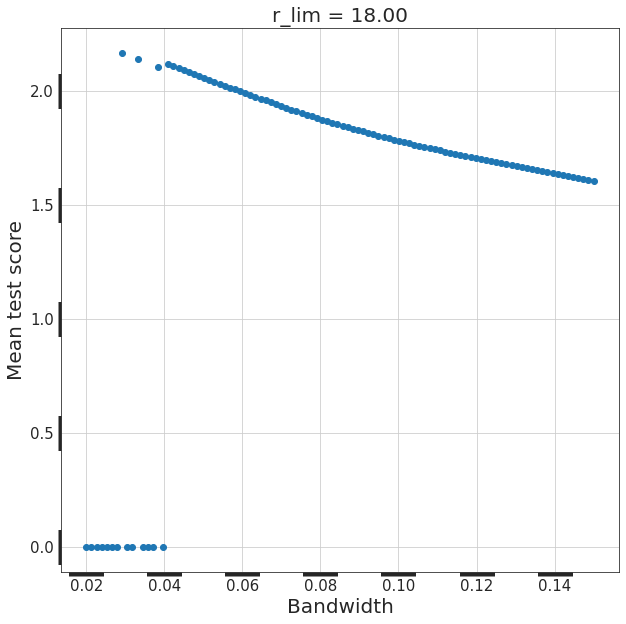

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.scatter(results["param_bandwidth"], results["mean_test_score"], marker='o')
ax.set_xlabel("Bandwidth", fontsize=20)
ax.set_ylabel("Mean test score", fontsize=20)
ax.set_title("r_lim = {:.2f}".format(mlim), fontsize=20)

ax.grid()

ax.xaxis.set_tick_params(labelsize=15, width=35)
ax.yaxis.set_tick_params(labelsize=15, width=35)

### Kernel density estimation

In [10]:
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, kernel='epanechnikov', metric='haversine',
                                                    algorithm="ball_tree", **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [11]:
#This bandwidth is the one I calculate before for Hydra-Centaurus data, but I think I need to recalculate it, because
#0.015 was just the smaller value in the array of possible bandwidths to be tested, so I have to test with lower values
# bandwidth = 0.039
# bandwidth = bandwidth["bandwidth"]
xx, yy, zz = kde2D(x, y, bandwidth=bandwidth, xbins=xbins, ybins=ybins)

In [12]:
cl_names = ["N3393", "A1060", "N3054", "N3087", "Antlia", "N3347", "N3250", "N3256", "N3263"]

cl_ras = [162.09, 159.17, 148.61, 149.78, 157.51, 160.69, 156.63, 156.96, 157.30]

cl_decs = [-25.16, -27.52, -25.70, -34.22, -35.32, -36.35, -39.94, -43.90, -44.12]

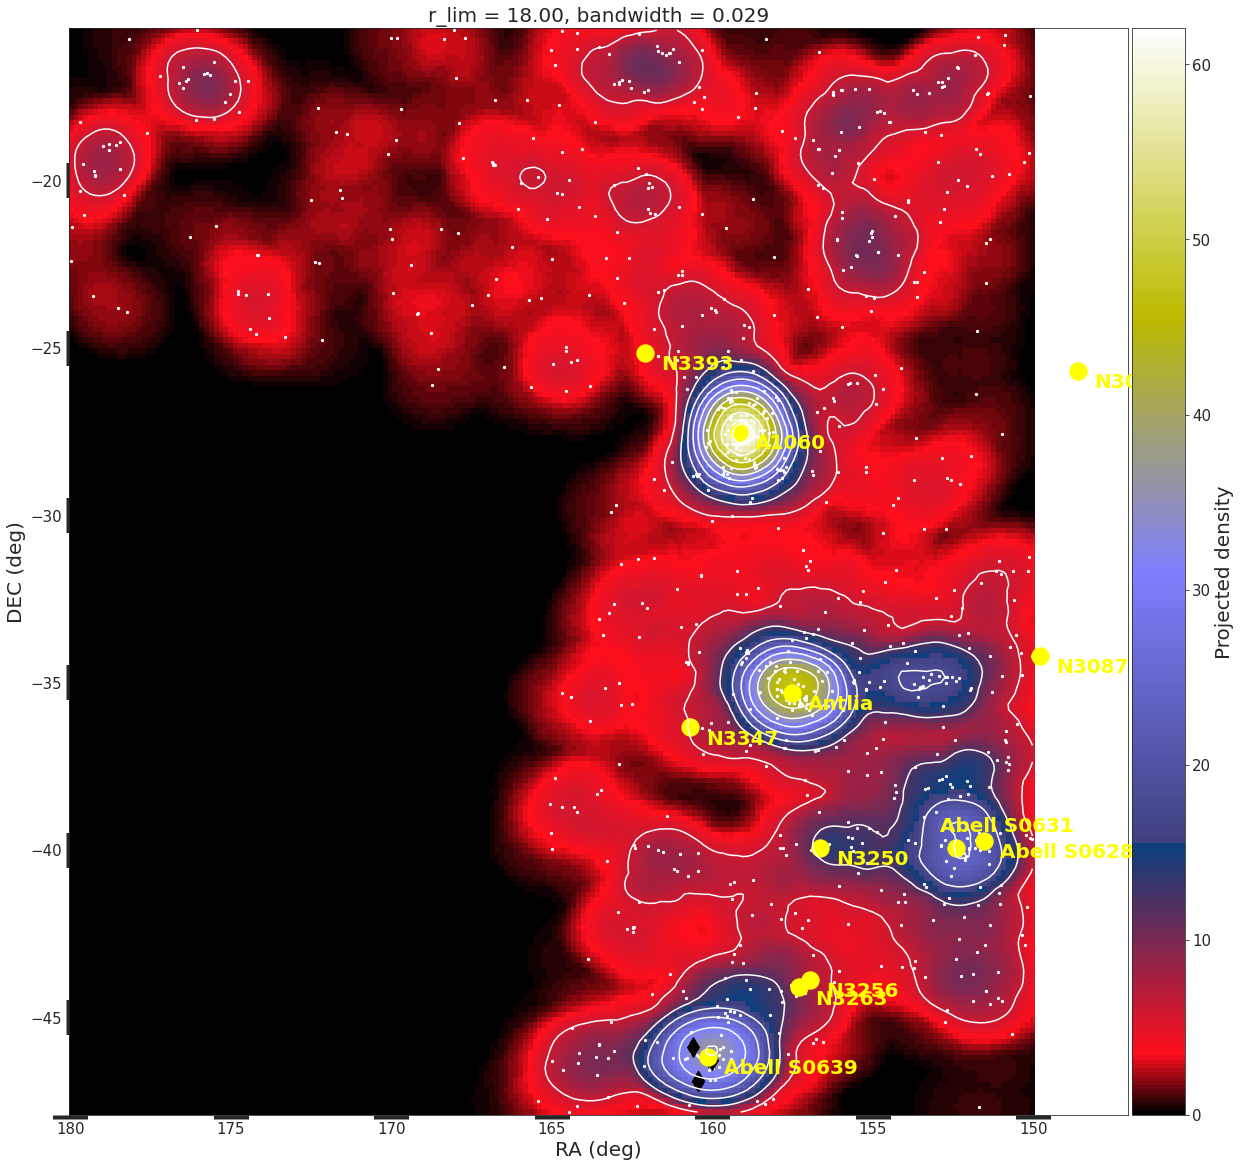

In [17]:
fontsize = 20
labelsize = 15
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz, cmap='gist_stern')
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=5, color='white')
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title("r_lim = {:.2f}, bandwidth = {:.3f}".format(mlim, bandwidth), fontsize=fontsize)

# ax.scatter(x=ra_s[mask_s], y=dec_s[mask_s], s=200, color="black", marker="d")
ax.scatter(x=ra_s[m1], y=dec_s[m1], s=200, color="black", marker="d")
ax.contour(np.rad2deg(xx), np.rad2deg(yy), zz, colors='white', levels=10, extend='min')


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Projected density", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

# ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=labelsize, width=35)
ax.yaxis.set_tick_params(labelsize=labelsize, width=35)

dx = 0.5
# for ra, dec, text in zip(ra_s[m], dec_s[m], obj_name[m]):
#     ax.text(ra-dx, dec-dx, s=text, fontsize=30, fontweight='bold', color='yellow')

for ra_i, dec_i, text in zip(cl_ras, cl_decs, cl_names):
    ax.scatter(ra_i, dec_i, marker='o', s = 300, color="yellow")
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=fontsize, fontweight='bold', color='yellow')
    
ax.scatter(x=ra_s[obj1], y=dec_s[obj1], s=300, color="yellow", marker="o")
ax.text(ra_s[obj1]-dx, dec_s[obj1]-dx, s="Abell S0639", fontsize=fontsize, fontweight='bold', color='yellow')

ax.scatter(x=ra_s[obj2], y=dec_s[obj2], s=300, color="yellow", marker="o")
ax.text(ra_s[obj2]+dx, dec_s[obj2]+dx, s="Abell S0631", fontsize=fontsize, fontweight='bold', color='yellow')

ax.scatter(x=ra_s[obj3], y=dec_s[obj3], s=300, color="yellow", marker="o")
ax.text(ra_s[obj3]-dx, dec_s[obj3]-dx, s="Abell S0628", fontsize=fontsize, fontweight='bold', color='yellow')

ax.invert_xaxis()

In [14]:
m1 = (dec_s > -48) & (dec_s < -45) & (ra_s < 161) & (ra_s > 159) & (z_s < 0.1)

print(obj_name[m1])

obj1 = obj_name == "ABELL S0639"

print(dec_s[obj1])
print(ra_s[obj1])

748      HDCE 0600
751    ABELL S0639
765       SSCC 224
766       SSCC 223
774      LDCE 0747
Name: Object Name, dtype: object
751   -46.19478
Name: DEC, dtype: float64
751    160.14115
Name: RA, dtype: float64


In [15]:
m2 = (dec_s > -41) & (dec_s < -39) & (ra_s < 153) & (ra_s > 152) & (z_s < 0.1)

print(obj_name[m2])

obj2 = obj_name == "ABELL S0631"

445      LDCE 0708
452      HDCE 0566
453    ABELL S0631
Name: Object Name, dtype: object


In [16]:
m3 = (dec_s > -36) & (dec_s < -34) & (ra_s < 158) & (ra_s > 156) & (z_s < 0.1)

print(obj_name[m3])

obj3 = obj_name == "ABELL S0628"

597      [STH2017] 100014
618      [STH2017] 101382
637    PSZ2 G272.88+19.14
645           ABELL S0636
646    Antlia GROUP NED02
Name: Object Name, dtype: object


### Calculate KDE by hand to see if sklearn is doing it right
We have to calculate the KDE for a given point and compare with the KDE computed by sklearn

In [38]:
def sph_dist(alpha1, delta1, alpha2, delta2):
    '''
    Calculate the distance between two points over a spherical surface
    
    Parameters
    -----------
    alpha1: float
    right ascencion of point 1
    
    delta1: float
    declination of point 1
    
    alpha2: float
    right ascencion of point 2
    
    delta2: float
    declination of point 2
    '''
    return np.sqrt((alpha2 - alpha1)**2 + np.cos(delta1)*np.cos(delta2)*(delta2 - delta1)**2)

In [69]:
def sph_dist2(alpha1, delta1, alpha2, delta2):
    '''
    Calculate the distance between two points over a spherical surface (this one is more precise)
    
    Parameters
    -----------
    alpha1: float
    right ascencion of point 1
    
    delta1: float
    declination of point 1
    
    alpha2: float
    right ascencion of point 2
    
    delta2: float
    declination of point 2
    '''
    return np.arccos(np.sin(delta1)*np.sin(delta2) + np.cos(delta1)*np.cos(delta2)*np.cos(alpha2-alpha1))

Haversine metric: have a look at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html

In [18]:
def haversine(x1, y1, x2, y2):
    '''
    Calculate the distance between points (x1, y1) and (x2, y2) using haversine metric
    
    Basically, x1 and x2 are the right ascencions, and y1 and y2 are the declinations
    '''
    
    return 2*np.arcsin(np.sqrt(np.sin((x2-x1)/2)**2 + np.cos(x1)*np.cos(x2)*np.sin((y2-y1)/2)**2))

In [164]:
def epanechnikov(x):
    '''
    Epanechnikov Kernel
    '''
    return (3/4)*(1 - x**2)

In [200]:
i = 30
j = 40

ra_test = xx[i, j] #X position (RA)
dec_test = yy[i, j] #Y position (DEC)

In [201]:
# distances = sph_dist2(ra_test, dec_test, x, y)
distances = haversine(ra_test, dec_test, x, y)
mask = (distances / bandwidth) <= 1
N = len(x)
D = 2 #Two-dimensional space

kde_test = 1/(N*bandwidth**D) * np.sum(epanechnikov(distances[mask]/bandwidth))

print("The KDE at (x, y) = ({:.2f}, {:.2f}) is {:.3f}".format(ra_test, dec_test, kde_test))

The KDE at (x, y) = (2.79, -0.61) is 5.921


In [202]:
print("The KDE at (x, y) = ({:.2f}, {:.2f}), by sklearn, is {:.3f}".format(ra_test, dec_test, zz[i, j]))

The KDE at (x, y) = (2.79, -0.61), by sklearn, is 6.172


### Calculate the density contrast in several regions of the Supercluster

The density contrast is defined by <br>

$$
\delta = \frac{\Sigma - \bar{\Sigma}}{\bar{\Sigma}} = \frac{\Sigma}{\bar{\Sigma}} -1 
$$

where $\Sigma$ is the density at a certain point or region, and $\bar{\Sigma}$ is the mean density at a reference region. Here, our idea is to consider a series of rings around the center of certain overdense regions, calculate the median density of the outermost ring, and use the median density of the others rings to calculate the contrast density as a function of the radius.

In [36]:
#Defining the center of Hydra (in degress)
ra_0 = np.deg2rad(159.17)
dec_0 = np.deg2rad(-27.524)

#Defining the radius of 1R200 around the center (in degrees)
#R200 = 1.4Mpc + scale of 0.247 Kpc/" ==> radius = 1.5744º
hydra_radius = np.deg2rad(1.5744)

In [37]:
distances_from_hydra_center = haversine(ra_0, dec_0, xx, yy)

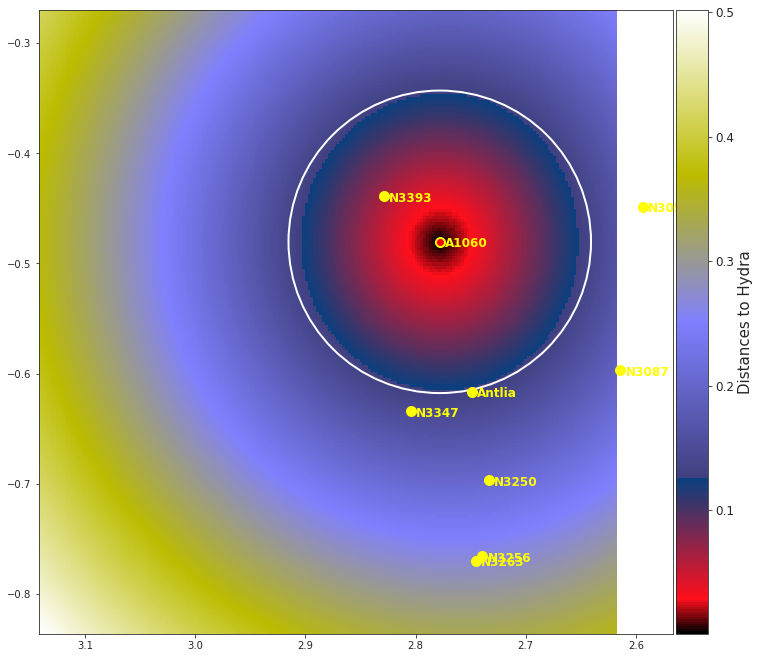

In [196]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.plot(ra_0, dec_0, marker='o', color='red')
sc1 = ax.pcolormesh(xx, yy, distances_from_hydra_center, cmap='gist_stern')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Distances to Hydra", fontsize=15)
cbar.ax.tick_params(labelsize=12)

OneR200 = plt.Circle((ra_0, dec_0), 5*hydra_radius, linestyle='-', edgecolor='white', facecolor="None", lw=2, label=r'$1 r_{200} = 1.5744^{\circ}$')
ax.add_patch(OneR200)

dx = 0.005
for ra_i, dec_i, text in zip(np.deg2rad(cl_ras), np.deg2rad(cl_decs), cl_names):
    ax.scatter(ra_i, dec_i, marker='o', s = 100, color="yellow")
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=12, fontweight='bold', color='yellow')

ax.set_aspect("equal")
ax.invert_xaxis()

In [86]:
dr = hydra_radius / 10
radii = np.arange(dr, 5*hydra_radius, dr)

density_r = []
for i in range(1, len(radii)):
    annulus_i = (distances_from_hydra_center > radii[i-1]) & (distances_from_hydra_center < radii[i])
    
    median_density_inside_annulus = np.median(zz[annulus_i])
    density_r.append(median_density_inside_annulus)
    
density_r = np.asarray(density_r)
contrast_density = (density_r - density_r[-1]) / density_r[1]

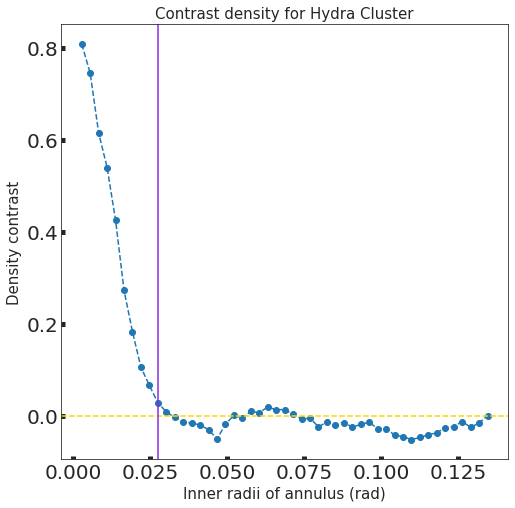

In [122]:
fontsize=15
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.plot(radii[:-1], contrast_density, '--o')
ax.set_title("Density contrast for Hydra Cluster", fontsize=fontsize)
ax.set_xlabel("Inner radii of annulus (rad)", fontsize=fontsize)
ax.set_ylabel("Density contrast", fontsize=fontsize)

ax.axhline(y=0, color="gold", linestyle='--')
ax.axvline(x=hydra_radius, color="blueviolet")

ax.xaxis.set_tick_params(labelsize=20, width=5, direction='in')
ax.yaxis.set_tick_params(labelsize=20, width=5, direction='in')

#### In order to calculate the density contrast for all Hydra-Centaurus, we will need to estimate the local background density at each point, so that we can use it as our "reference" density ($\bar{\Sigma}$) 

One idea is to estimate the background at several different points of the Supercluster, in which there are no apparent overdensities or underdensities, and then use a 2D interpolation to extrapolate it for all the region.

### Calculate the mean density at some given points of the background.

Result:  there seems to be a gradient in the background density, even using the Gaia crossmatched data. We still have to use some declination dependent procedure to calculate the background.

In [49]:
#Defining the points at which I will estimate the background
ra_bg = np.array([153.16, 155.03, 164.70, 151.97, 162.37, 164.07])
dec_bg = -np.array([29.56, 43.28, 25.26, 19.47, 34.51, 38.70])

radius = 1.6

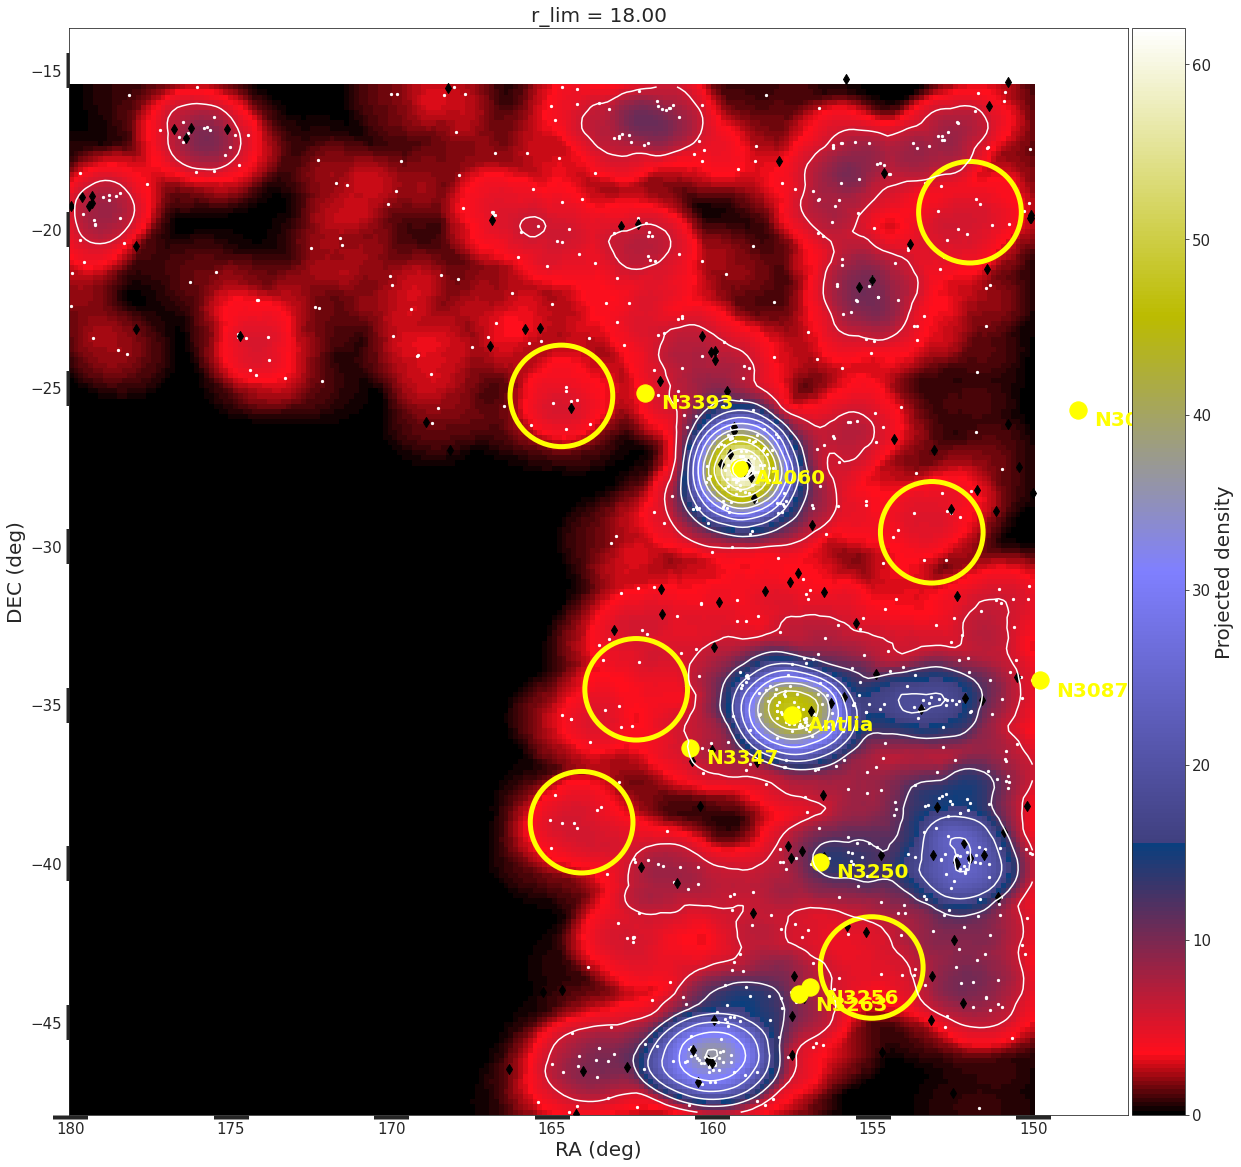

In [51]:
fontsize = 20
labelsize = 15

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz, cmap='gist_stern')
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=5, color='white')
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title("r_lim = {:.2f}".format(mlim), fontsize=fontsize)

ax.scatter(x=ra_s[mask_s], y=dec_s[mask_s], s=50, color="black", marker="d")
ax.contour(np.rad2deg(xx), np.rad2deg(yy), zz, colors='white', levels=10, extend='min')


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Projected density", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

# ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=labelsize, width=35)
ax.yaxis.set_tick_params(labelsize=labelsize, width=35)

for ra_bg_i, dec_bg_i in zip(ra_bg, dec_bg):
    circle = plt.Circle((ra_bg_i, dec_bg_i), radius, linestyle='-', edgecolor='yellow', facecolor="None", lw=5)
    ax.add_patch(circle)
#     ax.scatter(ra_bg, dec_bg, s=500, color="orange")

dx = 0.5
for ra_i, dec_i, text in zip(cl_ras, cl_decs, cl_names):
    ax.scatter(ra_i, dec_i, marker='o', s = 300, color="yellow")
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=fontsize, fontweight='bold', color='yellow')
    
ax.invert_xaxis()

In [26]:
median_density = []
for ra_bg_i, dec_bg_i in zip(np.deg2rad(ra_bg), np.deg2rad(dec_bg)):
    distances_i = haversine(ra_bg_i, dec_bg_i, xx, yy)
    circle_i = (distances_i < np.deg2rad(radius))
    median_density_i = np.median(zz[circle_i])
    median_density.append(median_density_i)

median_density = np.asarray(median_density)

In [28]:
background_mean = np.mean(median_density)
print("The mean value of density at the background selected points is {:.3f}".format(background_mean))

The mean value of density at the background selected points is 4.737


In [243]:
def std_deviation(mu, X):
    return np.sqrt((X - mu)**2)

In [262]:
background_std_deviation = std_deviation(background_mean, median_density)
print("The standard deviation for the background selected points are", background_std_deviation)

The standard deviation for the background selected points are [0.13168088 0.13168088 0.1625596  0.39232294 0.54556921 0.58391396]


In [251]:
background_std_deviation_all = np.std(median_density)
print("The standard deviation overall for the background selected points is {:.3f}".format(background_std_deviation_all))

The standard deviation overall for the background selected points is 0.375


Text(0.5, 0, 'Standard deviation')

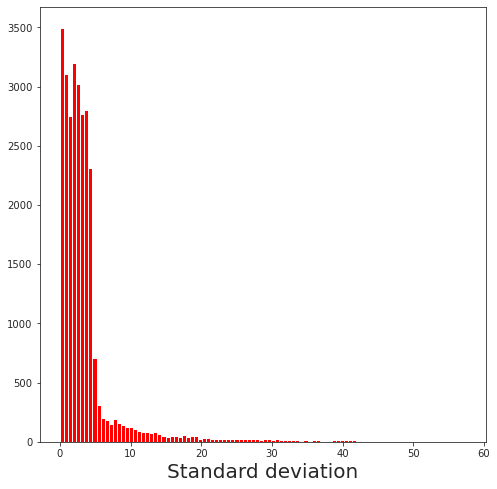

In [260]:
std_deviation_all_points = std_deviation(background_mean, zz.flatten()[zz.flatten() > 1e-9])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.hist(std_deviation_all_points, color="red", bins=100)
ax.set_xlabel("Standard deviation", fontsize=20)

#### Average number of galaxies per unit area

In [207]:
num_of_galaxies = []
for ra_bg_i, dec_bg_i in zip(np.deg2rad(ra_bg), np.deg2rad(dec_bg)):
    distances_i = haversine(ra_bg_i, dec_bg_i, x, y)
    circle_i = (distances_i < np.deg2rad(radius))
    n_i = np.sum(circle_i)
    num_of_galaxies.append(n_i)

print(num_of_galaxies)

[9, 8, 8, 10, 7, 9]


#### Histograms of density

Peak of the distribution = 1.656


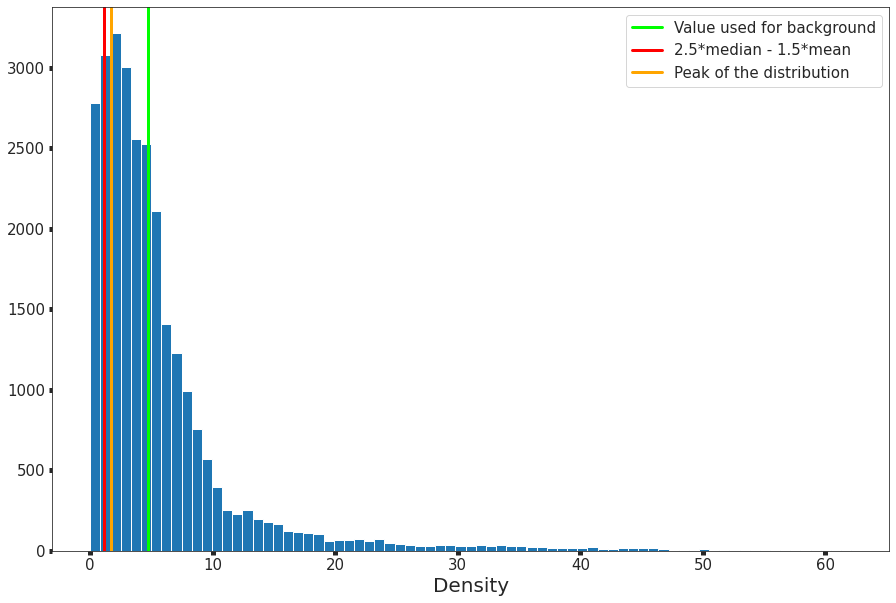

In [147]:
labelsize = 15

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

hist = ax.hist(zz.flatten()[zz.flatten() > 1e-9], bins=75)

mean = np.mean(zz.flatten()[zz.flatten() > 1e-9])
median = np.median(zz.flatten()[zz.flatten() > 1e-9])
mode1 = hist[1][np.argmax(hist[0])]
mode2 = 2.5*median - 1.5*mean

ax.axvline(background_mean, color="lime", label="Value used for background", lw=3)
ax.axvline(mode2, color="red", label="2.5*median - 1.5*mean", lw=3)
ax.axvline(mode1, color="orange", label="Peak of the distribution", lw=3)
ax.set_xlabel("Density", fontsize=20)

ax.xaxis.set_tick_params(labelsize=labelsize, width=5)
ax.yaxis.set_tick_params(labelsize=labelsize, width=5)

plt.legend(fontsize=15)


print("Peak of the distribution before correcting for borders = {:.3f}".format(mode1))

Peak of the distribution after correcting for borders = 1.656


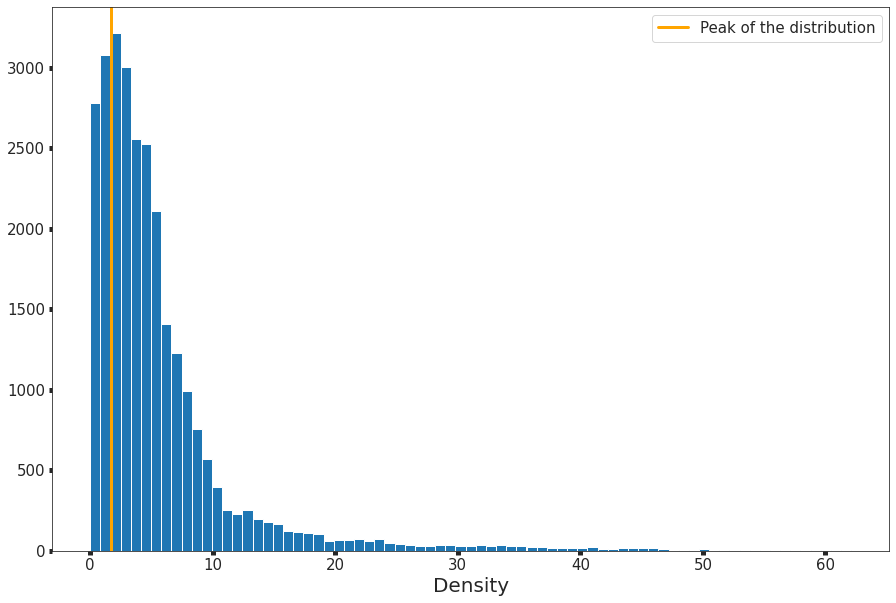

In [168]:
labelsize = 15

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

dens = zz_without_borders.flatten()[~np.isnan(zz_without_borders.flatten())]
# dens = zz.flatten()[~np.isnan(zz.flatten())]
hist = ax.hist(dens, bins=75)

mean = np.mean(dens)
median = np.median(dens)
mode1 = hist[1][np.argmax(hist[0])]
mode2 = 2.5*median - 1.5*mean

# ax.axvline(background_mean, color="lime", label="Value used for background", lw=3)
# ax.axvline(mode2, color="red", label="2.5*median - 1.5*mean", lw=3)
ax.axvline(mode1, color="orange", label="Peak of the distribution", lw=3)
ax.set_xlabel("Density", fontsize=20)

ax.xaxis.set_tick_params(labelsize=labelsize, width=5)
ax.yaxis.set_tick_params(labelsize=labelsize, width=5)

plt.legend(fontsize=15)


print("Peak of the distribution after correcting for borders = {:.3f}".format(mode1))

#### We will define the density background as the mode (or peak of the distribution) of density inside a region of one bandwidth distant from the border of the region where there is data from S-PLUS

In [184]:
xx, yy, zz = kde2D(x, y, bandwidth=bandwidth, xbins=xbins, ybins=ybins)

In [187]:
zz[zz < 1e-9] = np.nan

In [179]:
#Here I am kind of deleting the borders of the density map by considering as "region without data" all the points with density=0
#Then, I calculate the distance of all points in the grid to every point without data (which I define as nan)
#If the distance of a given point to a point with "NaN" is less then a bandwidth, then I set it as NaN as well
#Here, the bandwidth is in radians, because xx and yy are in radians as well

zz_t = np.zeros_like(zz)

for i in range(0, 200):
    for j in range(0, 200):
        dist = haversine(xx[i, j], yy[i, j], xx, yy)
        if np.isnan(zz[i, j]) == True: zz_t[dist < bandwidth] = np.nan
            
zz_without_borders = zz + zz_t

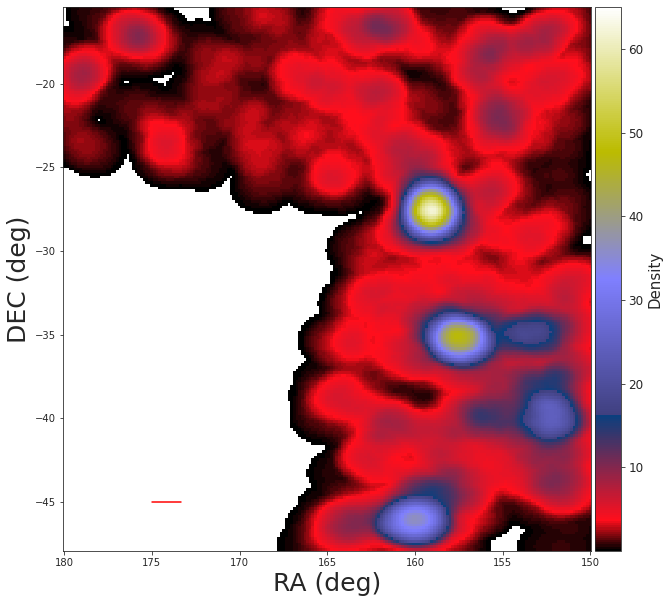

In [188]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz_without_borders, cmap='gist_stern', vmin=1e-3, vmax=65)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz, cmap='gist_stern', vmin=1e-3, vmax=65)

ax.plot([175, 175-np.rad2deg(bandwidth)], [-45, -45], color="red")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Density", fontsize=15)
cbar.ax.tick_params(labelsize=12)

ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)

# ax.invert_yaxis()
ax.invert_xaxis()

### Plot density as function of declination at three different values of right ascencion

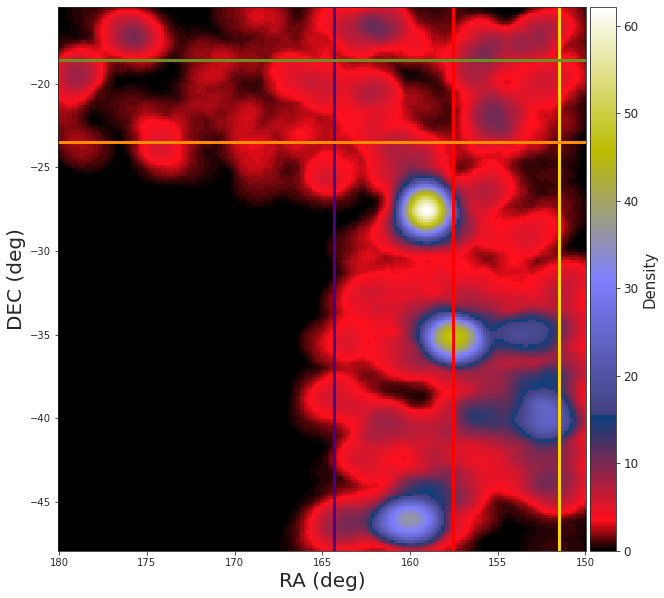

In [103]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz, cmap='gist_stern')

ax.axvline(np.rad2deg(xx)[10, 0], color="gold", linewidth=3)
ax.axvline(np.rad2deg(xx)[50, 0], color="red", linewidth=3)
ax.axvline(np.rad2deg(xx)[95, 0], color="indigo", linewidth=3)

ax.axhline(np.rad2deg(yy)[0, 150], color="darkorange", linewidth=3)
ax.axhline(np.rad2deg(yy)[0, 180], color="olivedrab", linewidth=3)

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Density", fontsize=15)
cbar.ax.tick_params(labelsize=12)

ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)

# ax.invert_yaxis()
ax.invert_xaxis()

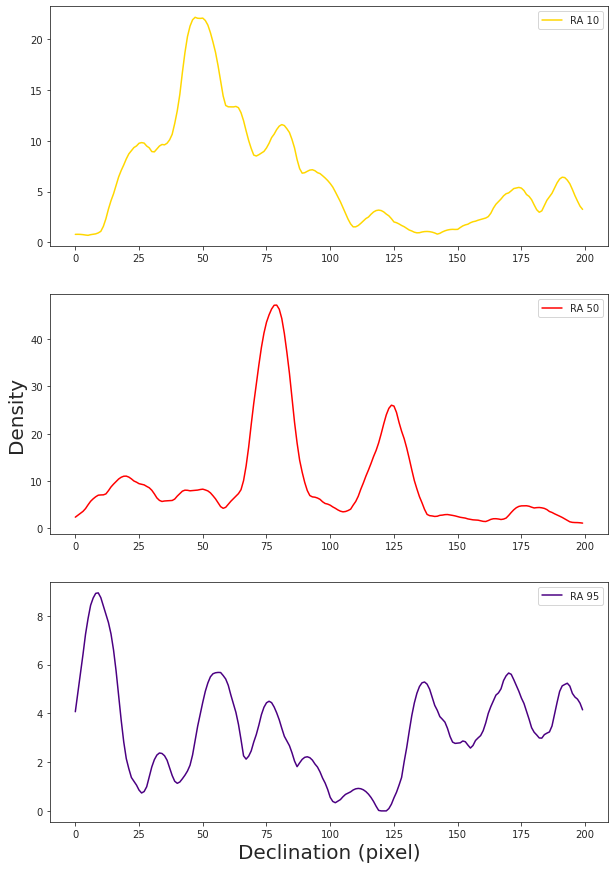

In [102]:
zz_ra10 = zz[10, :]
zz_ra50 = zz[50, :]
zz_ra95 = zz[95, :]

fontsize=20
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(np.arange(0, len(zz_ra10)), zz_ra10, color="gold", label="RA 10")
# ax1.axhline(np.median(zz_ra10), color="blue", linestyle='--', label="median")

ax2.plot(np.arange(0, len(zz_ra50)), zz_ra50, color="red", label="RA 50")
# ax2.axhline(np.median(zz_ra50), color="red", linestyle='--', label="median")

ax3.plot(np.arange(0, len(zz_ra95)), zz_ra95, color="indigo", label="RA 95")
# ax3.axhline(np.median(zz_ra95), color="indigo", linestyle='--', label="median")
    
ax3.set_xlabel("Declination (pixel)", fontsize=fontsize)
ax2.set_ylabel("Density", fontsize=fontsize)

ax1.legend()
ax2.legend()
ax3.legend()

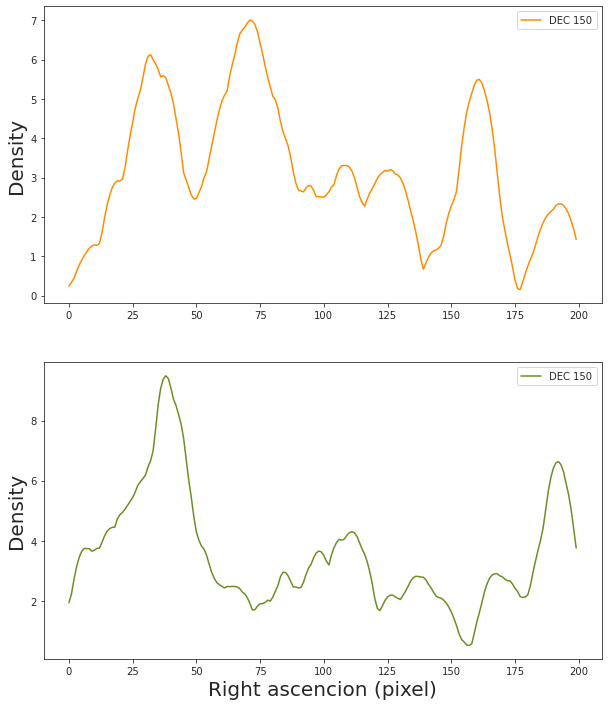

In [100]:
zz_dec150 = zz[:, 150]
zz_dec180 = zz[:, 180]

fontsize=20
fig = plt.figure(figsize=(10, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(np.arange(0, len(zz_dec150)), zz_dec150, color="darkorange", label="DEC 150")
ax2.plot(np.arange(0, len(zz_dec180)), zz_dec180, color="olivedrab", label="DEC 150")

ax1.set_ylabel("Density", fontsize=fontsize)
ax2.set_xlabel("Right ascencion (pixel)", fontsize=fontsize)
ax2.set_ylabel("Density", fontsize=fontsize)

ax1.legend()
ax2.legend()

## Contrast density map

In [29]:
zz_background = np.zeros(zz.shape)

#4.7 is the density I estimated for the background given some regions that seem to be on the background
zz_background[zz > 0] = background_mean

contrast_density = zz/zz_background - 1
contrast_density[np.isnan(contrast_density)] = -1

/tmp/ipykernel_1411932/3449342661.py:6: RuntimeWarning: invalid value encountered in true_divide
  contrast_density = zz/zz_background - 1


In [30]:
ra_vir = np.array([159.17, 157.51, 160.14])
dec_vir = np.array([-27.52, -35.32, -46.19])
radius_vir = np.array([1.5744, 1.37, 0.530])

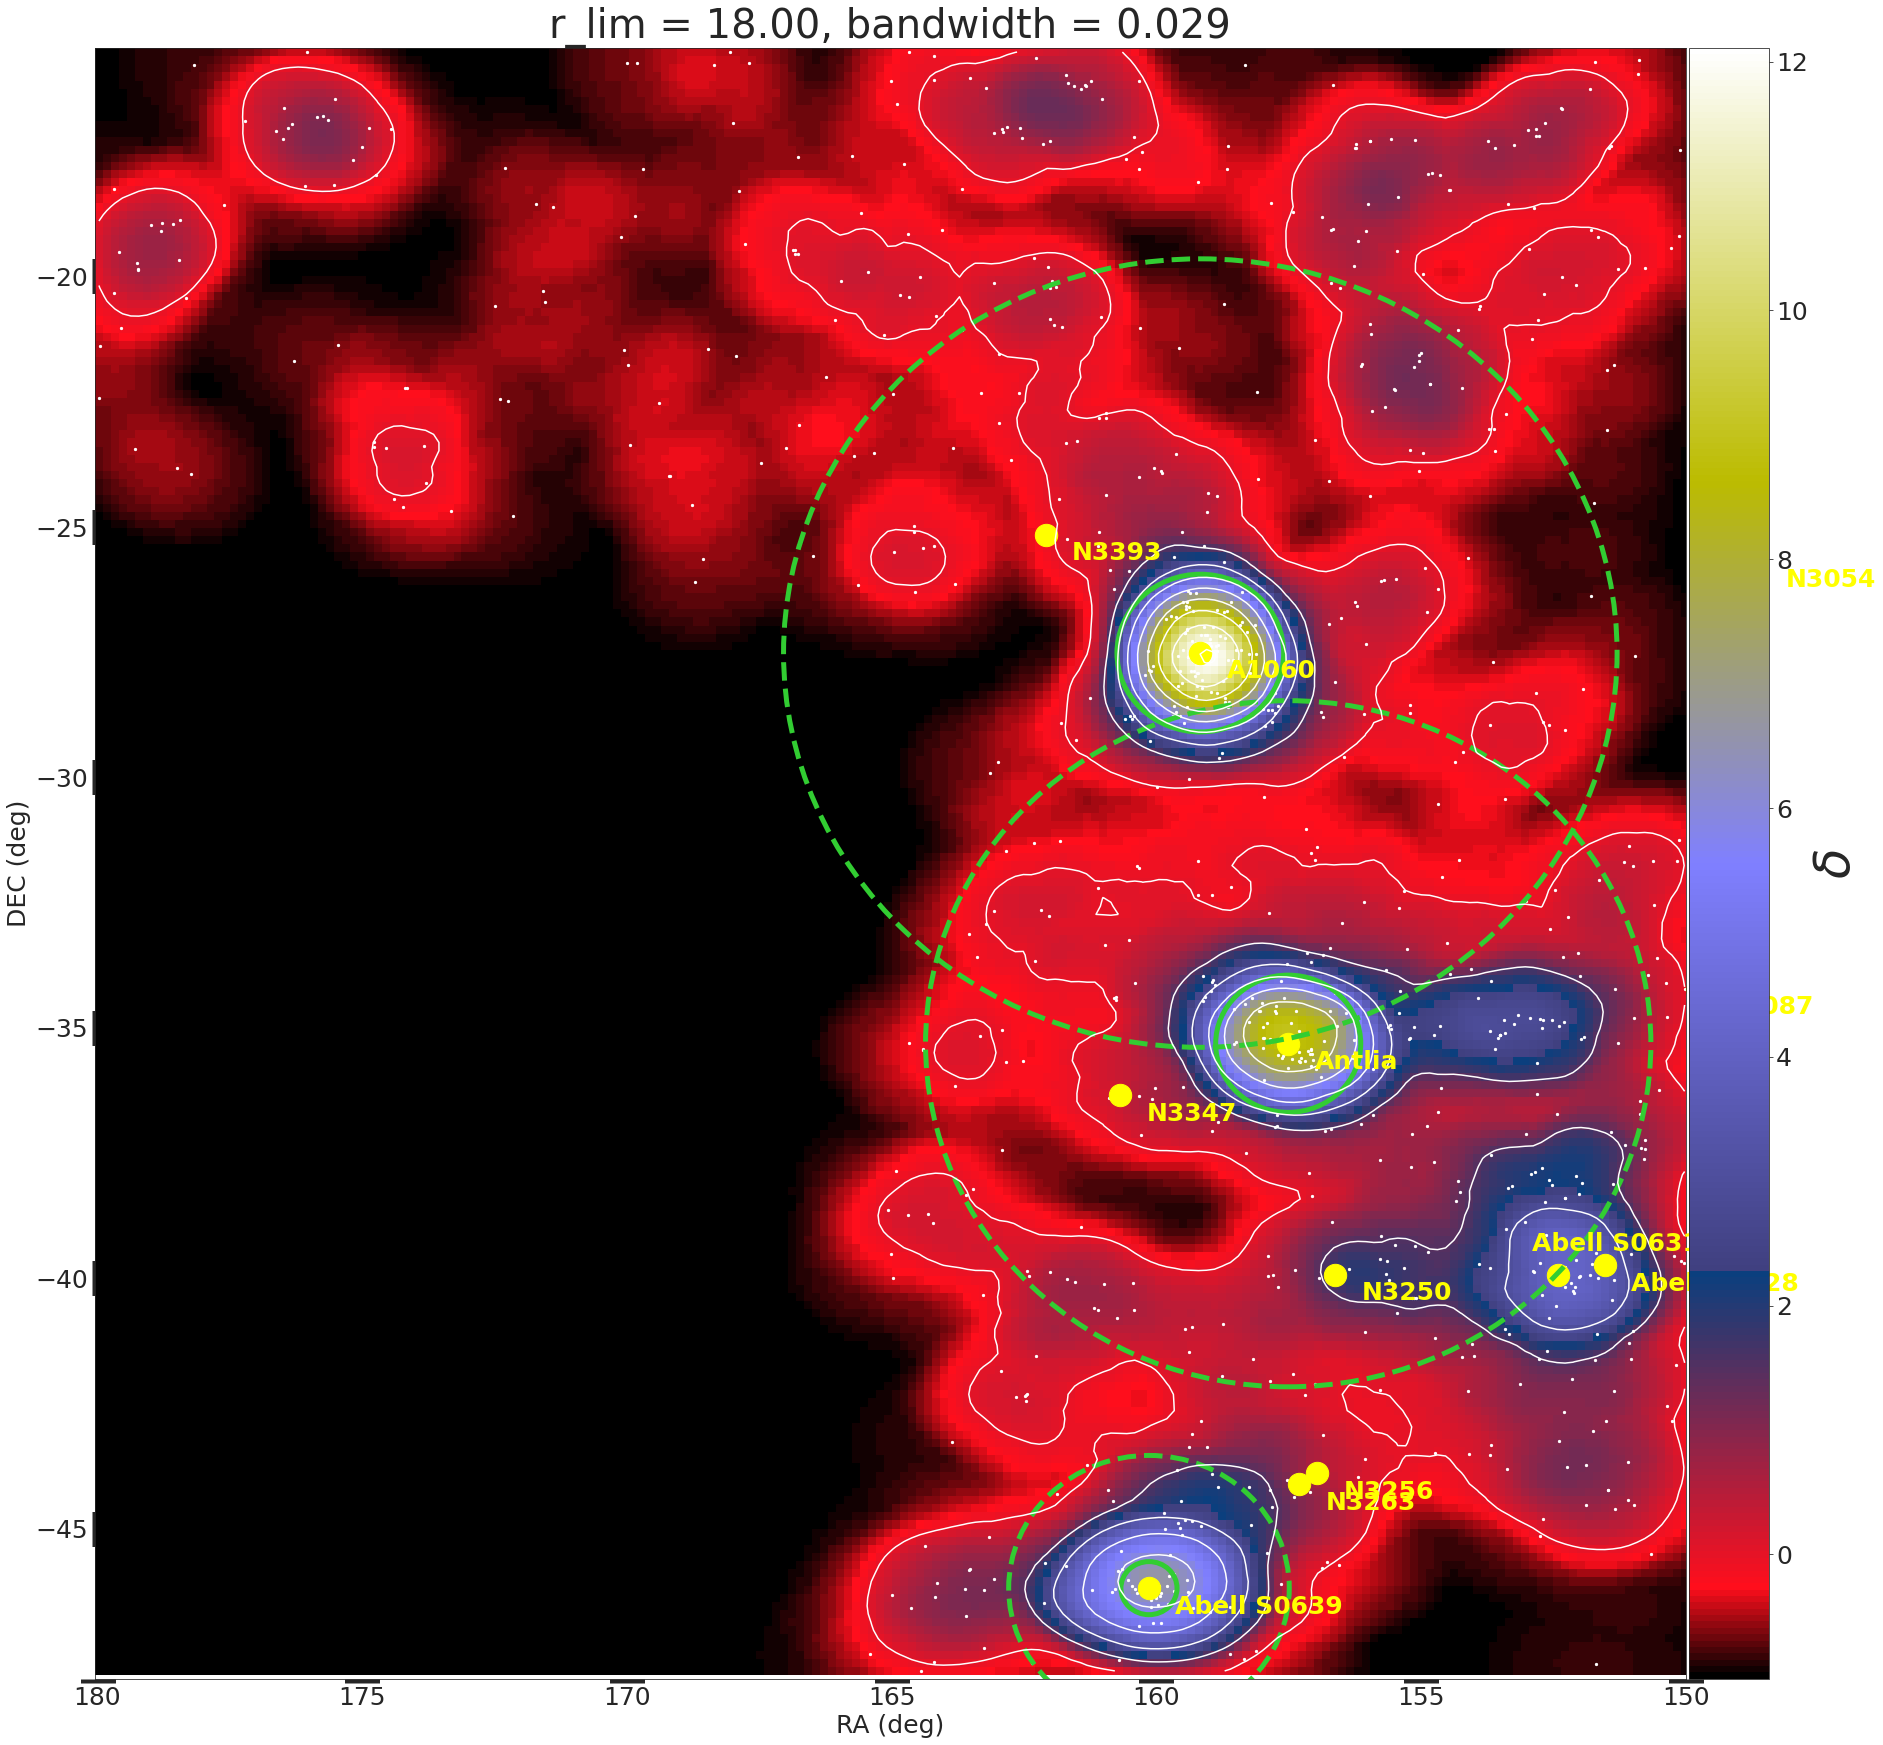

In [31]:
fontsize = 25
labelsize = 25
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), contrast_density, cmap='gist_stern')
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=5, color='white')
ax.set_title("Bandwidth = {:.4f}".format(bandwidth), fontsize=fontsize)
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title("r_lim = {:.2f}, bandwidth = {:.3f}".format(mlim, bandwidth), fontsize=40)

ax.contour(np.rad2deg(xx), np.rad2deg(yy), contrast_density, colors='white', levels=10, extend='min')


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$\delta$", fontsize=fontsize*2.0)
cbar.ax.tick_params(labelsize=labelsize)

# ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=labelsize, width=35)
ax.yaxis.set_tick_params(labelsize=labelsize, width=35)

dx = 0.5
for ra_i, dec_i, text in zip(cl_ras, cl_decs, cl_names):
    ax.scatter(ra_i, dec_i, marker='o', s = 500, color="yellow")
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=fontsize, fontweight='bold', color='yellow')
    
ax.scatter(x=ra_s[obj1], y=dec_s[obj1], s=500, color="yellow", marker="o")
ax.text(ra_s[obj1]-dx, dec_s[obj1]-dx, s="Abell S0639", fontsize=fontsize, fontweight='bold', color='yellow')

ax.scatter(x=ra_s[obj2], y=dec_s[obj2], s=500, color="yellow", marker="o")
ax.text(ra_s[obj2]+dx, dec_s[obj2]+dx, s="Abell S0631", fontsize=fontsize, fontweight='bold', color='yellow')

ax.scatter(x=ra_s[obj3], y=dec_s[obj3], s=500, color="yellow", marker="o")
ax.text(ra_s[obj3]-dx, dec_s[obj3]-dx, s="Abell S0628", fontsize=fontsize, fontweight='bold', color='yellow')


for ra_0, dec_0, radius in zip(ra_vir, dec_vir, radius_vir):
    FiveR200 = plt.Circle((ra_0, dec_0), 5*radius, linestyle='--', 
                          edgecolor='limegreen', facecolor="None", lw=5, label=r'$5 r_{200} = 7.872^{\circ}$')
    ax.add_patch(FiveR200)

    OneR200 = plt.Circle((ra_0, dec_0), radius, linestyle='-', 
                         edgecolor='limegreen', facecolor="None", lw=5, label=r'$1 r_{200} = 1.5744^{\circ}$')
    ax.add_patch(OneR200)

ax.set_ylim(-48)
ax.set_xlim(150)
ax.invert_xaxis()

### These next ideas can be useful just in cases where there is a gradient in the density map (when the background is not constants throughout the region)

#### Ideia 2: we want to create a sparse grid (like 20X20) representing the density values for the background, and then use this grid to interpolate and get a 200X200 grid for the background. The idea I had to create this 20X20 grid is to break the 200x200 grid into squares of 10X10. First, I will calculate the median density for each stripe in declination, and then eliminate all points of the grid with a density bigger than this median. Using the remaining points, I will then make the division of 10x10 and calculate the mean density inside each of these 10x10 squares.

In [29]:
from scipy import interpolate

In [53]:
xx, yy, zz = kde2D(x, y, bandwidth=bandwidth, xbins=xbins, ybins=ybins)

In [54]:
zz_background_dec = np.zeros(zz.shape)

width = 1
for i in range(0, len(zz), width):
    stripe = zz[:, i:i+width]
    stripe_median = np.median(stripe[stripe > 0])
    zz_background_dec[:, i:i+width][stripe > 0] = stripe_median

In [55]:
zz_background_ra = np.zeros(zz.shape)

width = 1
for i in range(0, len(zz), width):
    stripe = zz[i:i+width, :]
    stripe_median = np.median(stripe[stripe > 0])
    zz_background_ra[i:i+width, :][stripe > 0] = stripe_median

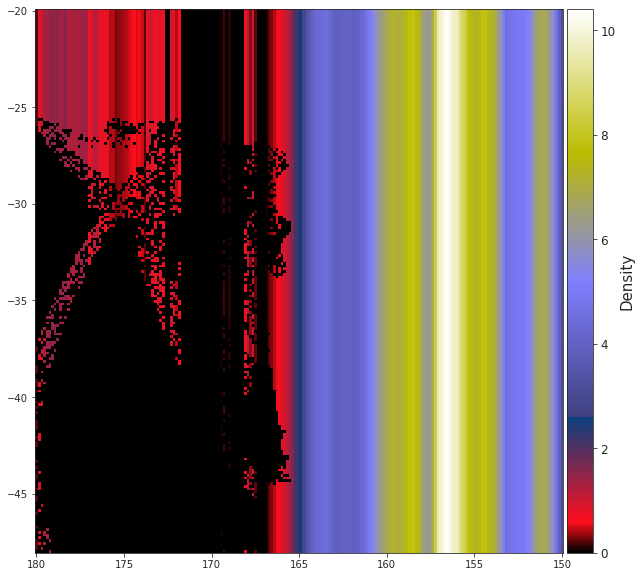

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz_background_ra, cmap='gist_stern')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Density", fontsize=15)
cbar.ax.tick_params(labelsize=12)

# ax.invert_yaxis()
ax.invert_xaxis()

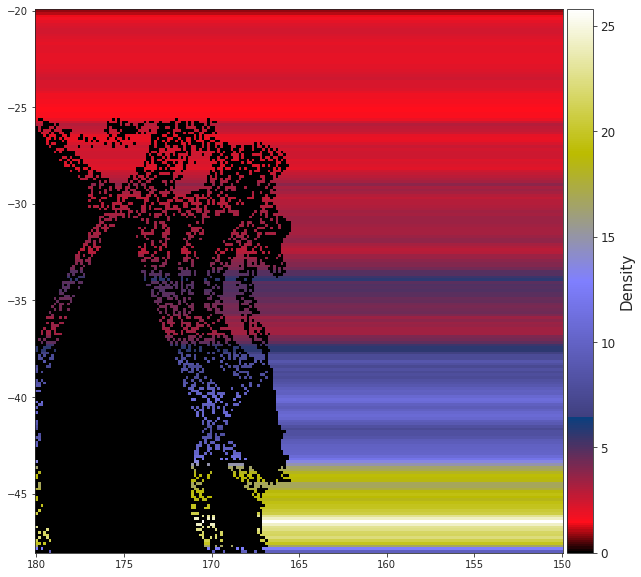

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz_background_dec, cmap='gist_stern')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Density", fontsize=15)
cbar.ax.tick_params(labelsize=12)

# ax.invert_yaxis()
ax.invert_xaxis()

In [56]:
background_rough = (0.7*zz_background_dec+0.3*zz_background_ra)

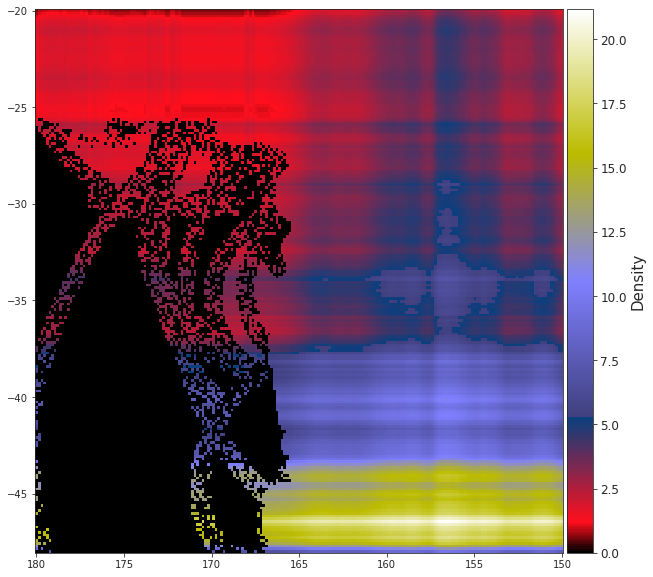

In [57]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), background_rough, cmap='gist_stern')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Density", fontsize=15)
cbar.ax.tick_params(labelsize=12)

# ax.invert_yaxis()
ax.invert_xaxis()

/tmp/ipykernel_388839/3463417918.py:3: RuntimeWarning: invalid value encountered in true_divide
  sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz/background_rough, cmap='gist_stern')


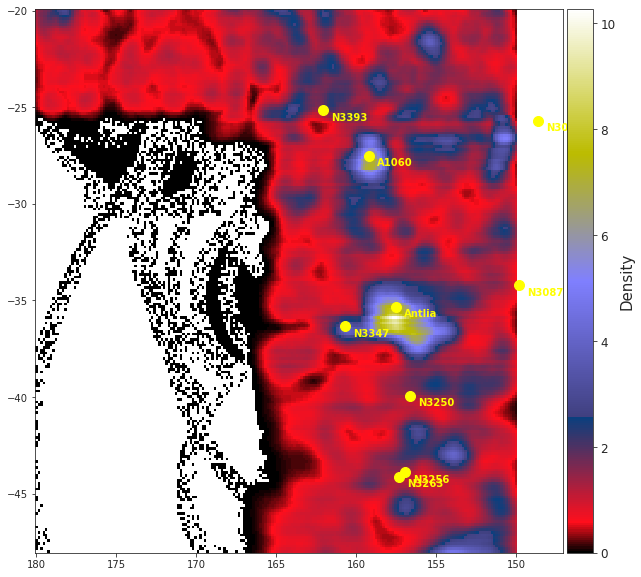

In [21]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz/background_rough, cmap='gist_stern')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Density", fontsize=15)
cbar.ax.tick_params(labelsize=12)

dx = 0.5
for ra_i, dec_i, text in zip(cl_ras, cl_decs, cl_names):
    ax.scatter(ra_i, dec_i, marker='o', s = 100, color="yellow")
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=10, fontweight='bold', color='yellow')

# ax.invert_yaxis()
ax.invert_xaxis()

In [22]:
from skimage.measure import block_reduce

roughness = 10
background_reduced = block_reduce(background_rough, block_size=(roughness,roughness), 
                                        func=np.mean, cval=np.mean(background_rough))

In [23]:
xbin_size_reduced = 200/roughness
ybin_size_reduced = 200/roughness

xbins_reduced=xbin_size_reduced*1j
ybins_reduced=ybin_size_reduced*1j

xx_reduced, yy_reduced = np.mgrid[x.min():x.max():xbins_reduced, y.min():y.max():ybins_reduced]

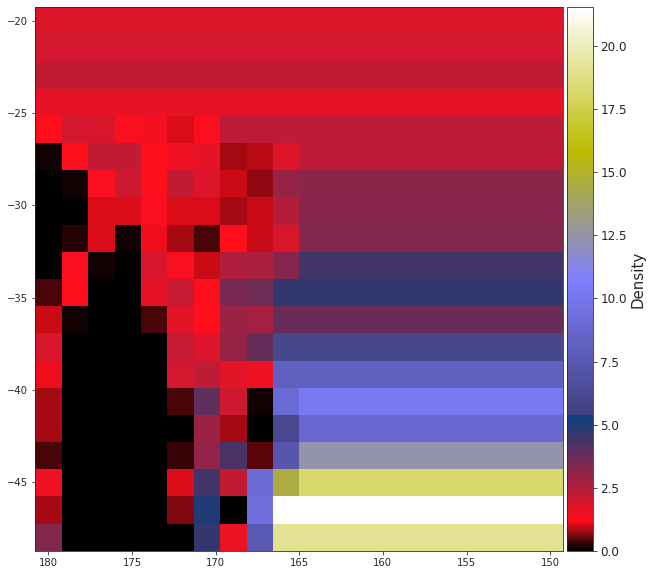

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx_reduced), np.rad2deg(yy_reduced), background_reduced, cmap='gist_stern')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Density", fontsize=15)
cbar.ax.tick_params(labelsize=12)

# ax.invert_yaxis()
ax.invert_xaxis()

In [25]:
x_interpolate = np.linspace(x.min(), x.max(), int(xbin_size_reduced))

y_interpolate = np.linspace(y.min(), y.max(), int(ybin_size_reduced))

In [28]:
interpolate_background = interpolate.interp2d(x_interpolate, y_interpolate, background_reduced, kind='linear')

In [29]:
x_smooth = np.linspace(x.min(), x.max(), int(xbin_size))

y_smooth = np.linspace(y.min(), y.max(), int(ybin_size))

background_smooth = interpolate_background(x_smooth, y_smooth)

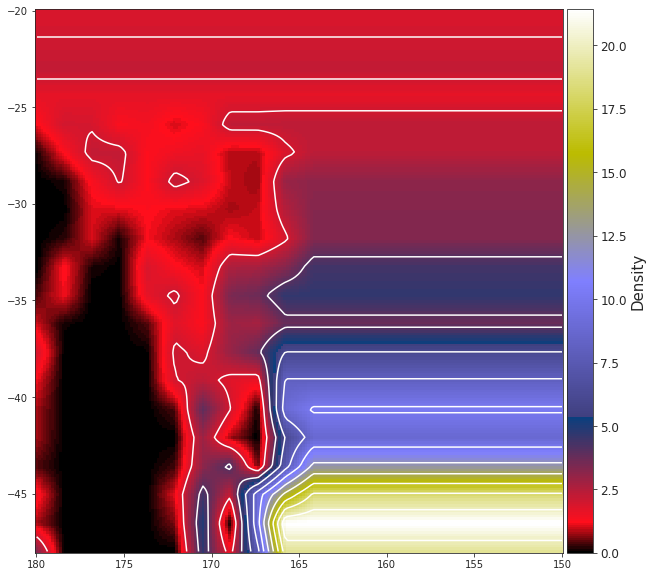

In [33]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), background_smooth, cmap='gist_stern')
ax.contour(np.rad2deg(xx), np.rad2deg(yy), background_smooth, colors='white', levels=10, extend='min')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Density", fontsize=15)
cbar.ax.tick_params(labelsize=12)

# ax.invert_yaxis()
ax.invert_xaxis()

/tmp/ipykernel_388839/2214622024.py:4: RuntimeWarning: invalid value encountered in true_divide
  sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz/background_smooth, cmap='gist_stern')
/tmp/ipykernel_388839/2214622024.py:5: RuntimeWarning: invalid value encountered in true_divide
  ax.contour(np.rad2deg(xx), np.rad2deg(yy), zz/background_smooth, colors='white', levels=10, extend='min')


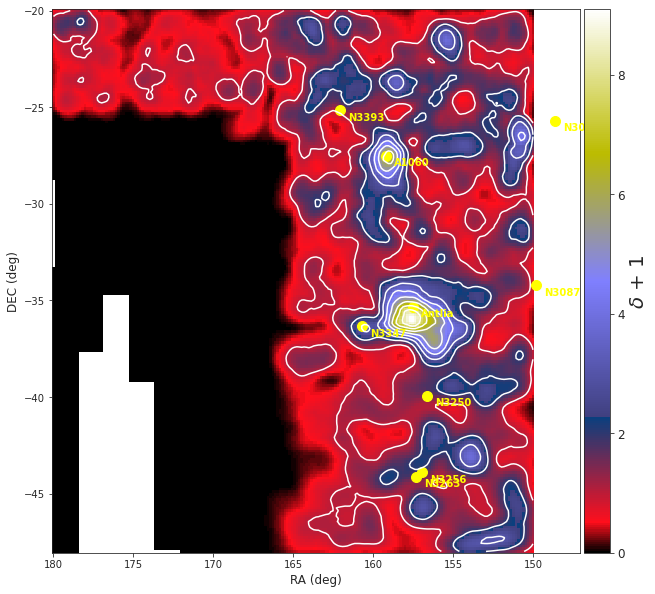

In [35]:
fontsize=12
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz/background_smooth, cmap='gist_stern')
ax.contour(np.rad2deg(xx), np.rad2deg(yy), zz/background_smooth, colors='white', levels=10, extend='min')

ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$\delta$ + 1", fontsize=20)
cbar.ax.tick_params(labelsize=12)

dx = 0.5
for ra_i, dec_i, text in zip(cl_ras, cl_decs, cl_names):
    ax.scatter(ra_i, dec_i, marker='o', s = 100, color="yellow")
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=10, fontweight='bold', color='yellow')

# ax.invert_yaxis()
ax.invert_xaxis()

In [36]:
stripes_ra = np.array([np.median(zz[i:i+10, :], axis=0) for i in range(0, int(len(zz)/2), 10)])

In [19]:
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema

In [21]:
def func1(x, c, d):
    return c*x + d

In [20]:
def func2(x, b, c, d):
    return b*x**2 + c*x + d

/home/elismar/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/elismar/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/elismar/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/elismar/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/elismar/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covarian

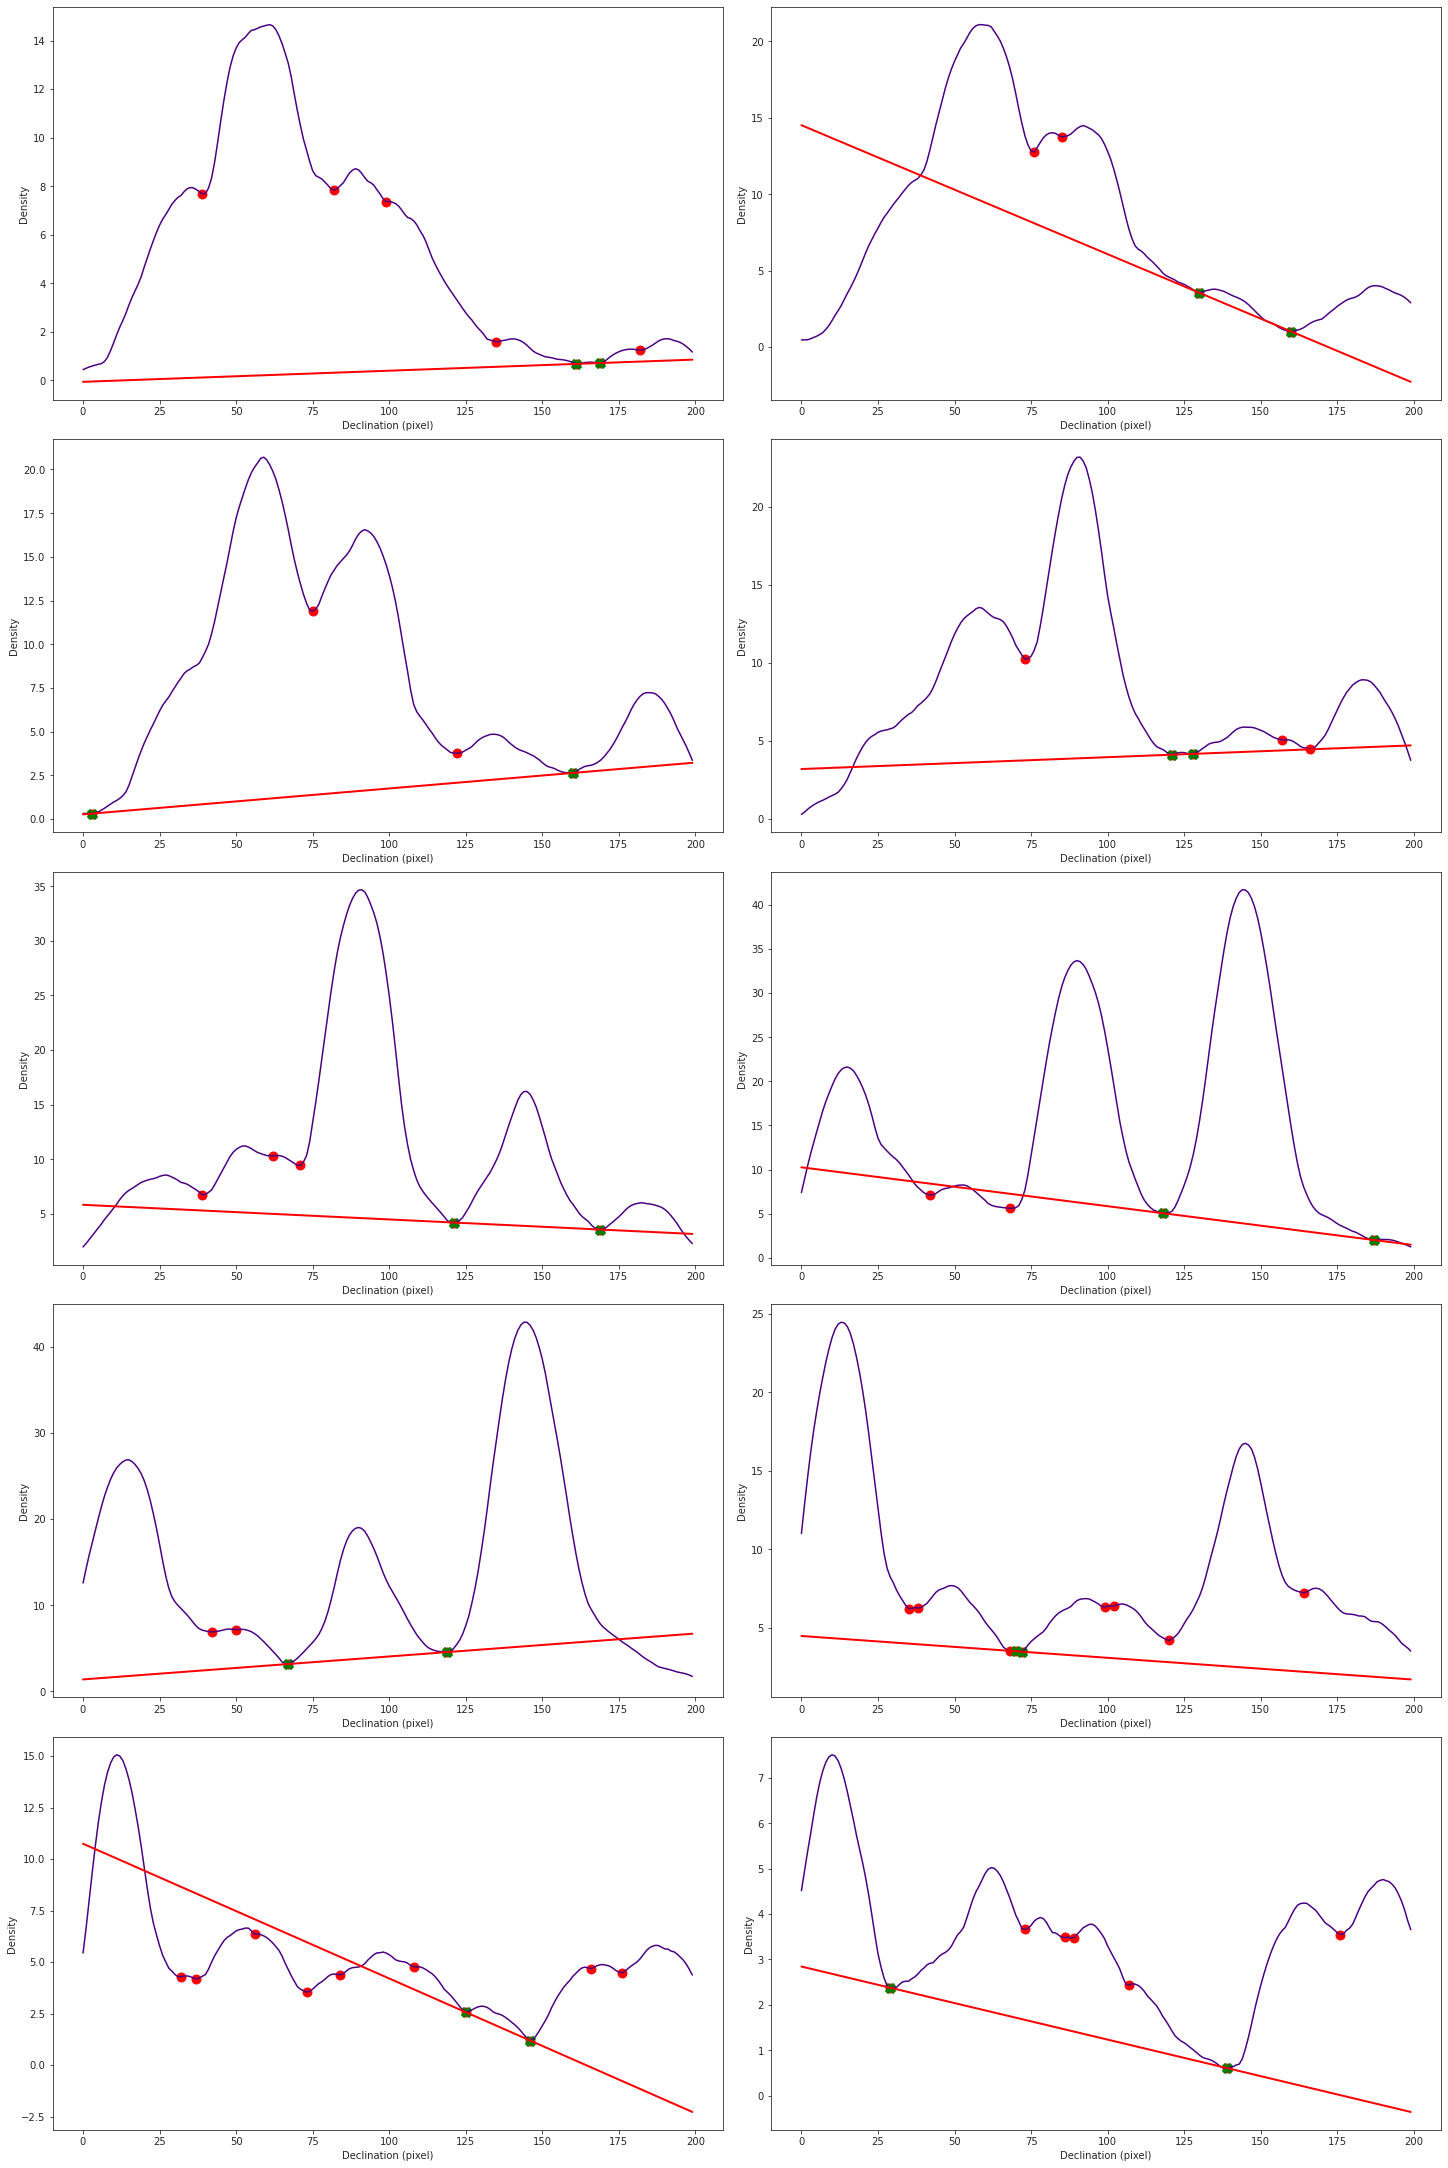

In [38]:
fig, axs = plt.subplots(5, 2, figsize=(20, 30), constrained_layout = True)

for ax, dens in zip(axs.ravel(), stripes_ra):
    mask = dens > 1e-4
    xdata = np.arange(0, len(dens))[mask]
    ydata = dens[mask]
    
    minima = argrelextrema(ydata, np.less)
    six_lowest_minima = np.sort(ydata[minima])[:2]
    six_lowest_minima_mask = np.isin(ydata[minima], six_lowest_minima)
    
    xdata_fit = minima[0][six_lowest_minima_mask]
    ydata_fit = ydata[minima][six_lowest_minima_mask]
    
    popt, pcov = curve_fit(func1, xdata_fit, ydata_fit)
    
    ax.scatter(minima[0], ydata[minima], color="red", marker='o', s=80)
    ax.scatter(xdata_fit, ydata_fit, 
                           color="green", marker="X", s=100)

    ax.plot(xdata, ydata, color="indigo")
    ax.plot(xdata, func1(xdata, *popt), linewidth=2.0, color='red')
    ax.set_xlabel("Declination (pixel)", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)

#### Idea 3: 
i) Start by "deleting the structures" by calculating the median at each stripe in declination, and then cutting for density values above some multiple of the median. <br>

ii) Substitute the density of the stripe by a value given by a linear fit over the remaining (not deleted) values of the density map at that stripe <br>

iii) This will generate a "rough" (200, 20) matrix for the density background, which needs to be interpolated to give a (200, 200) density background matrix. <br>

Result: the idea of fitting a linear function didn't seem to work well. The density background seems very weird.

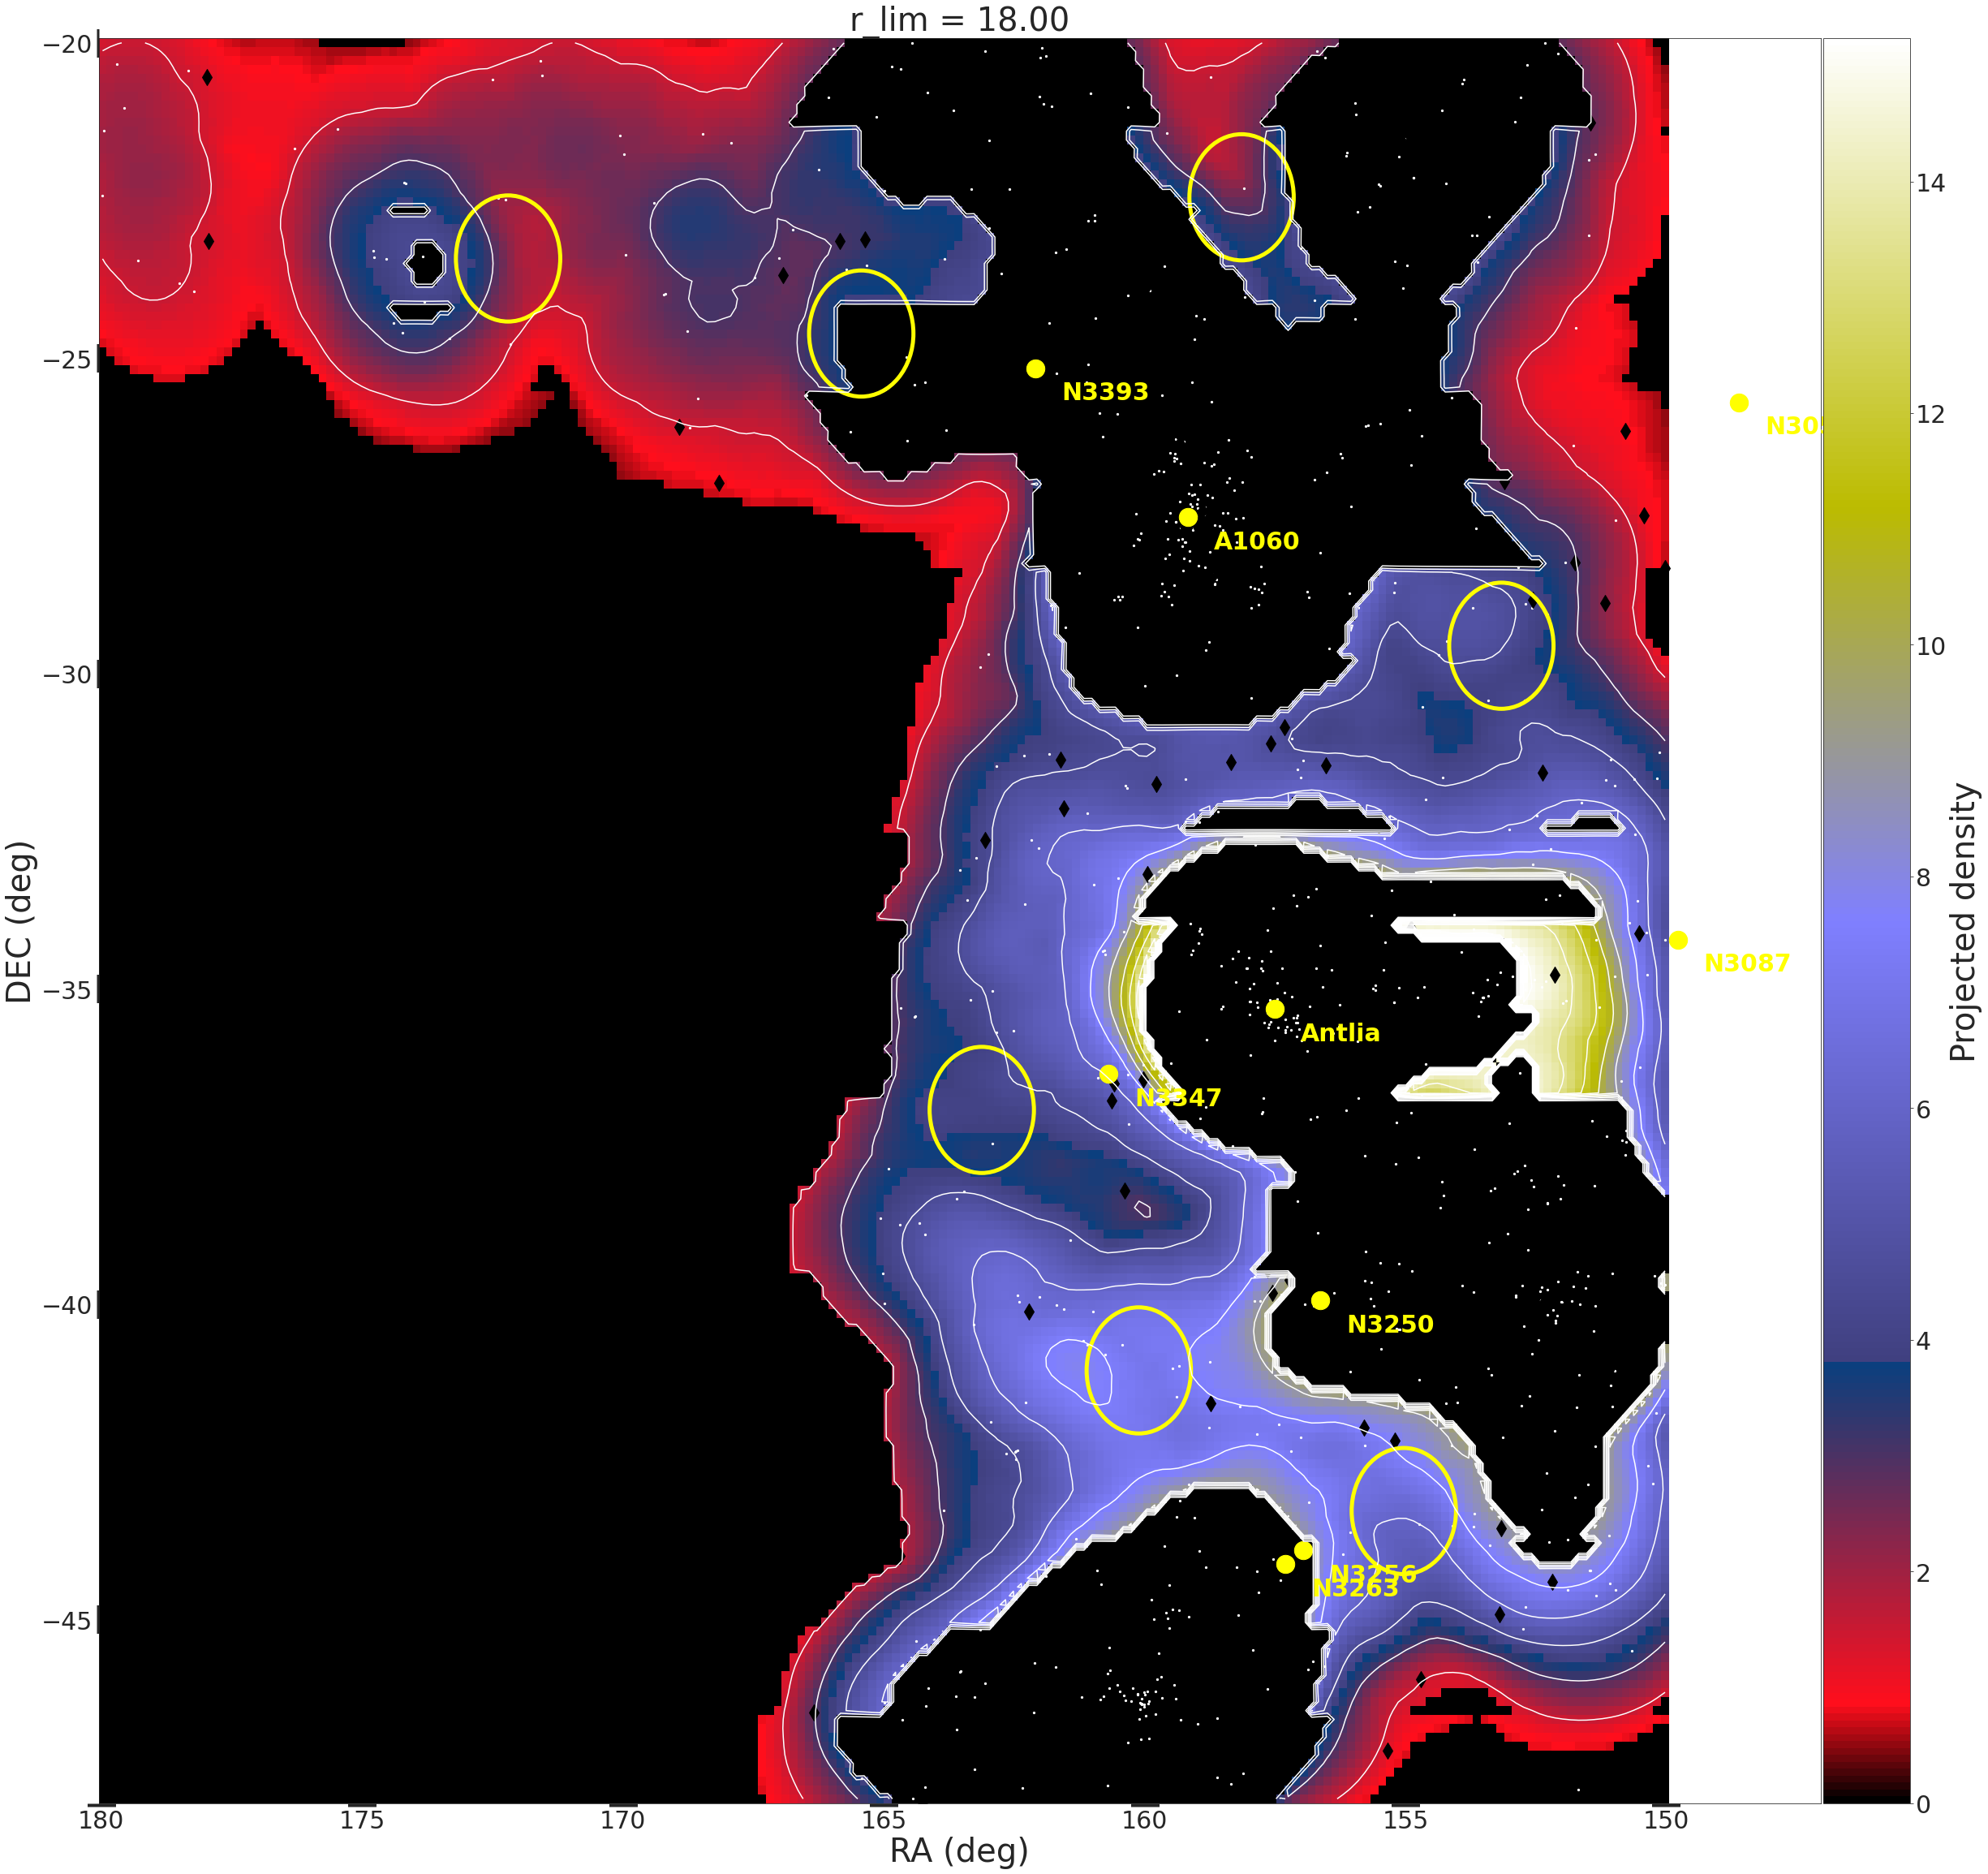

In [103]:
fontsize = 40
labelsize = 30

fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz, cmap='gist_stern')
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=5, color='white')
ax.set_title("Bandwidth = {:.4f}".format(bandwidth), fontsize=fontsize)
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title("r_lim = {:.2f}".format(mlim), fontsize=40)

ax.scatter(x=ra_s[mask_s], y=dec_s[mask_s], s=200, color="black", marker="d")
ax.contour(np.rad2deg(xx), np.rad2deg(yy), zz, colors='white', levels=10, extend='min')


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Projected density", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

# ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=labelsize, width=35)
ax.yaxis.set_tick_params(labelsize=labelsize, width=35)

dx = 0.5
for ra_i, dec_i, text in zip(cl_ras, cl_decs, cl_names):
    ax.scatter(ra_i, dec_i, marker='o', s = 500, color="yellow")
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=30, fontweight='bold', color='yellow')
    
ax.invert_xaxis()

In [51]:
xx, yy, zz = kde2D(x, y, bandwidth=bandwidth, xbins=xbins, ybins=ybins)

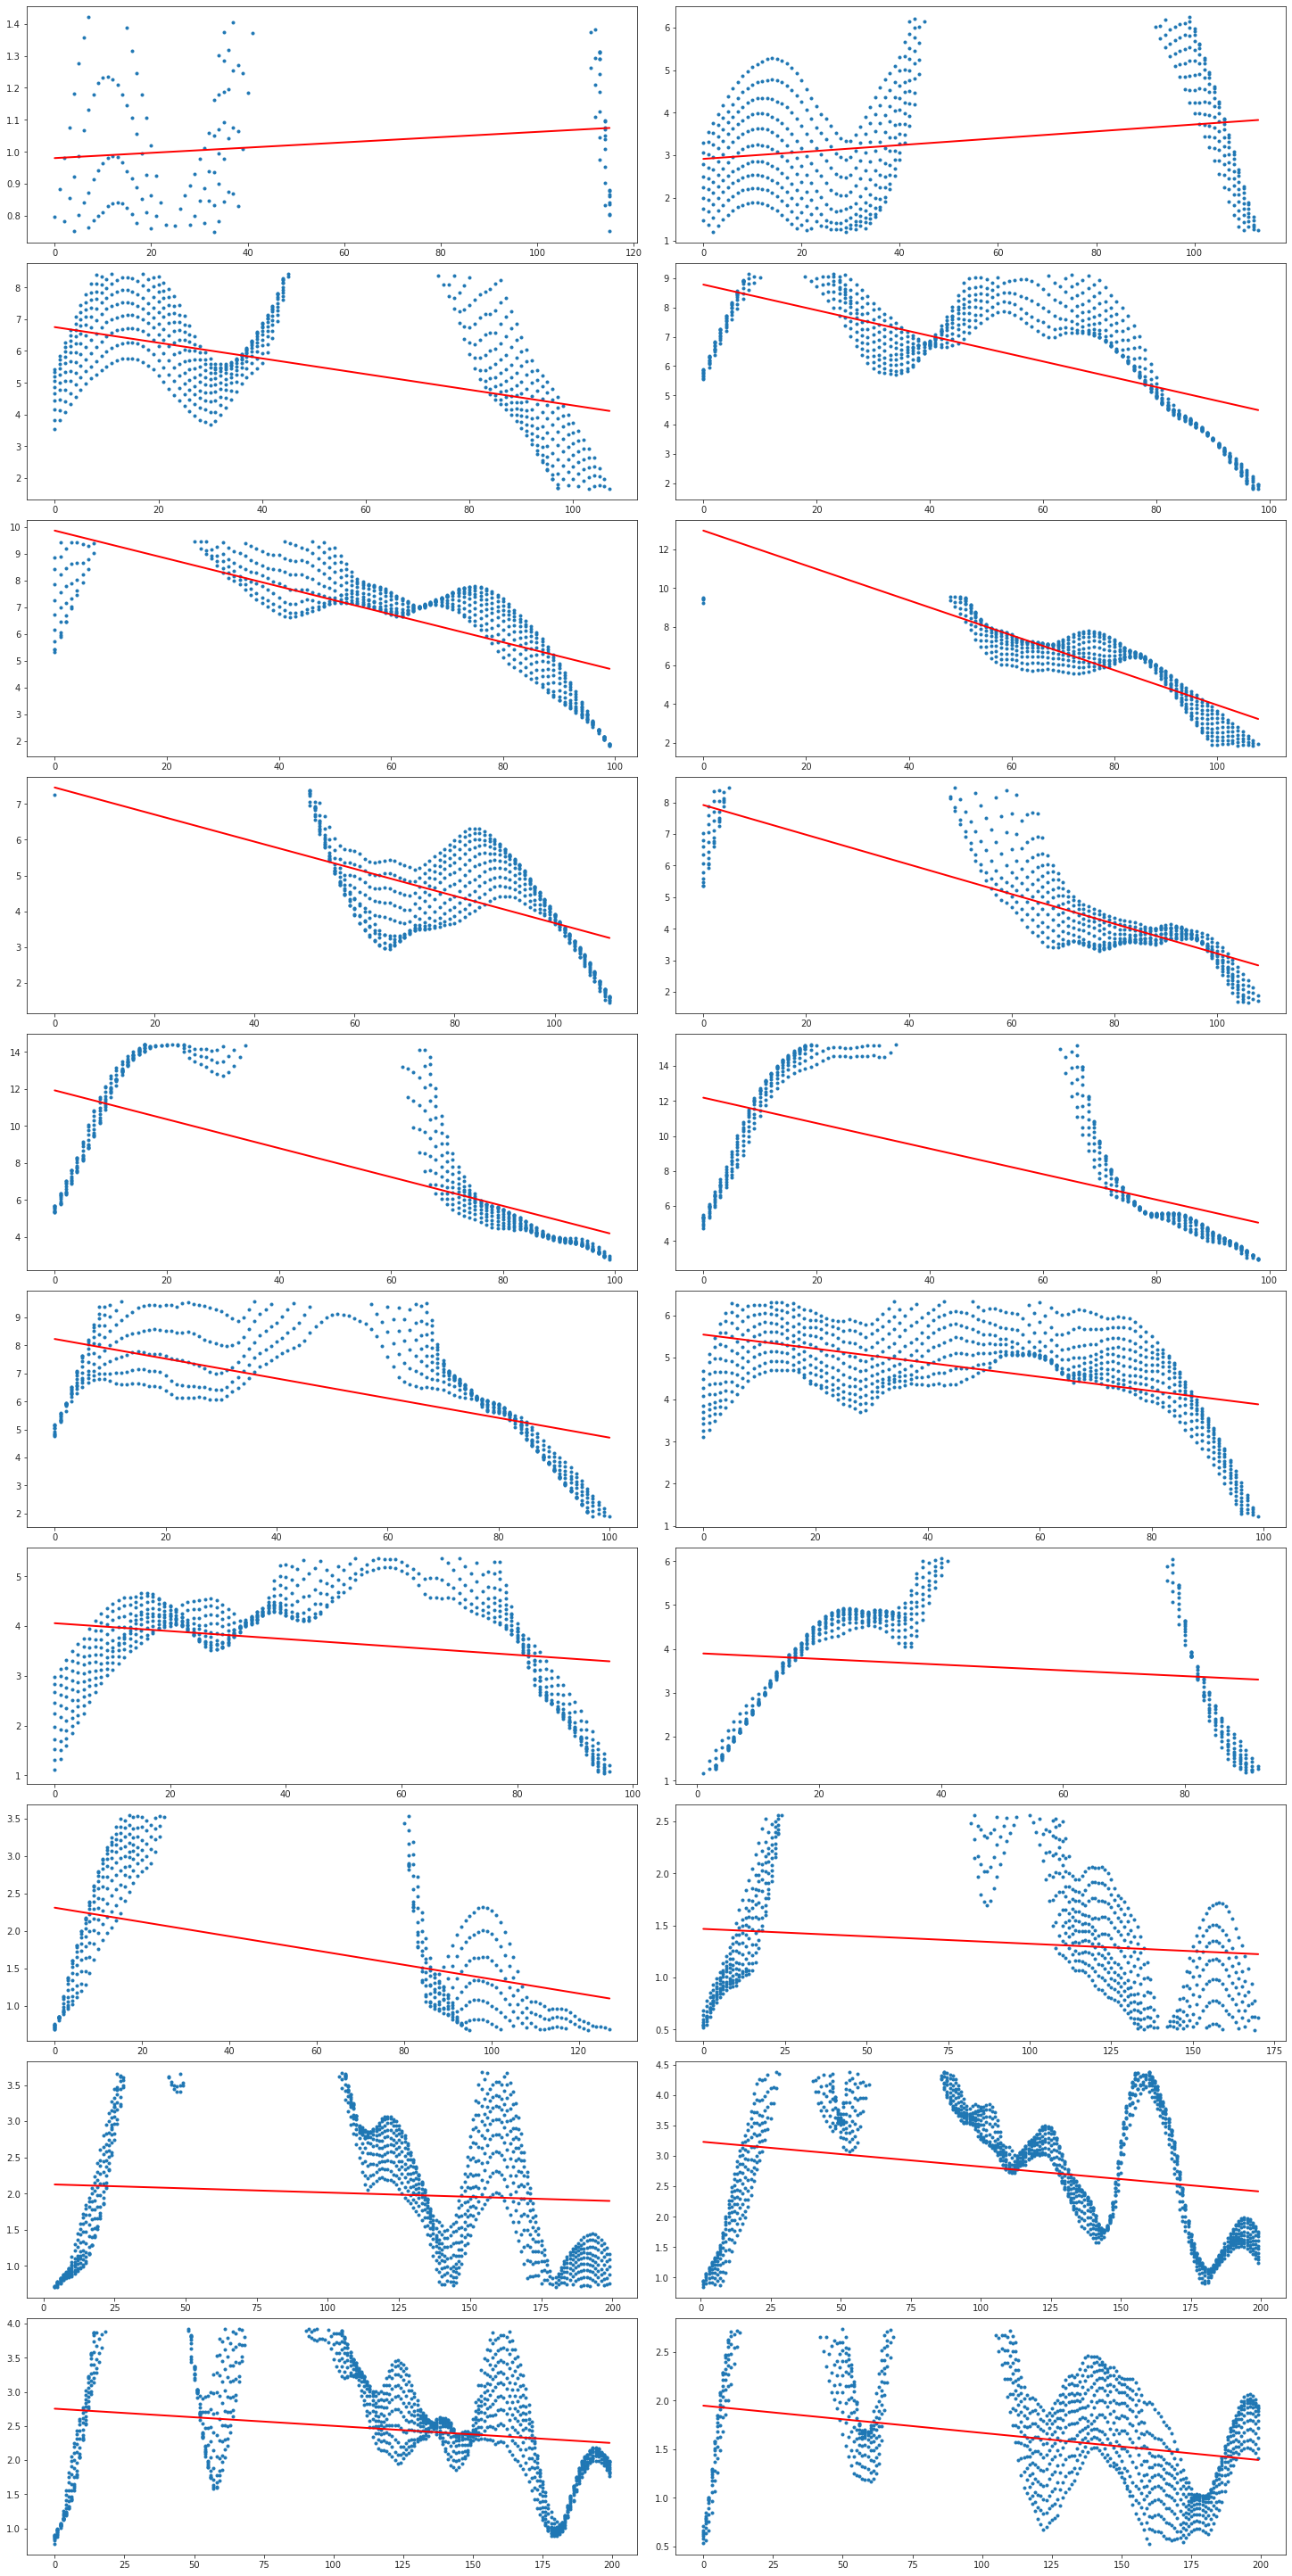

In [22]:
fig, axs = plt.subplots(10, 2, figsize=(20, 40), constrained_layout = True)
width = 10
zz_background_rough = np.zeros((200, int(200/width)))

for i, j, ax in zip(range(0, len(zz), width), range(np.size(zz_background_rough, axis=1)), axs.ravel()):
    stripe = zz[:, i:i+width]
    mask_above_zero = stripe > 1e-4
    m = np.median(stripe[mask_above_zero])
    mask = (stripe > 0.25*m) & (stripe < 1.3*m)
    stripe[~mask] = 0

    x = np.arange(len(stripe))
    y = stripe.flatten()
    x_repeat = np.repeat(x, 10)
    mask_above_zero = y > 0
    ydata = y[mask_above_zero]
    xdata = x_repeat[mask_above_zero]

    popt, pcov = curve_fit(func1, xdata, ydata)
    
    ax.scatter(xdata, ydata, marker='.')
    ax.plot(xdata, func1(xdata, *popt), linewidth=2.0, color='red')
    
    zz_background_rough[:, j] = func1(x, *popt)

In [34]:
zz_background_rough.T.shape

(20, 200)

In [37]:
ybin_size_reduced = np.size(zz_background_rough, axis=1)
ybins_reduced=ybin_size_reduced*1j

xx_interpolate, yy_interpolate = np.mgrid[x.min():x.max():xbins, y.min():y.max():ybins_reduced]

x_interpolate = np.linspace(x.min(), x.max(), int(xbin_size))
y_interpolate = np.linspace(y.min(), y.max(), int(ybin_size_reduced))

interpolate_background = interpolate.interp2d(x_interpolate, y_interpolate, zz_background_rough.T, kind='linear')

x_smooth = x_interpolate
y_smooth = np.linspace(y.min(), y.max(), int(ybin_size))

background_smooth = interpolate_background(x_smooth, y_smooth)

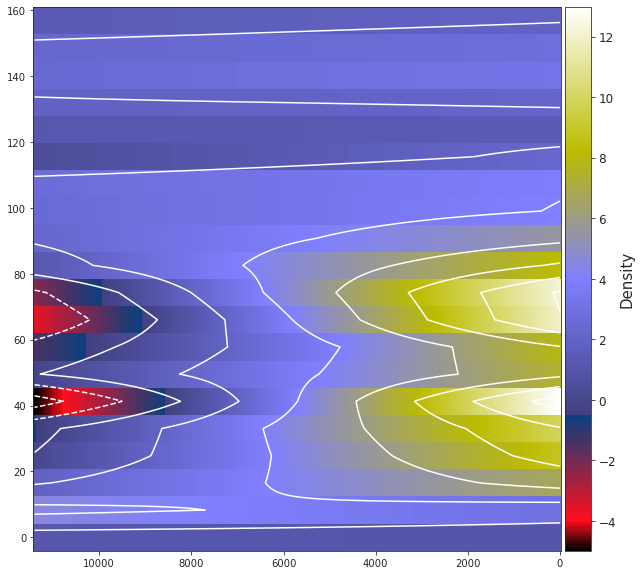

In [38]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx_interpolate), np.rad2deg(yy_interpolate), zz_background_rough, cmap='gist_stern')
ax.contour(np.rad2deg(xx_interpolate), np.rad2deg(yy_interpolate), zz_background_rough, colors='white', levels=10, extend='min')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Density", fontsize=15)
cbar.ax.tick_params(labelsize=12)

# ax.invert_yaxis()
ax.invert_xaxis()